In [1]:
import math
import pprint

import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.applications.densenet import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import pickle
import time
import json




%matplotlib inline

In [92]:
data_TSLA = pd.read_csv('../datasets/TSLA.csv', index_col='Date', parse_dates=[0])
data_TSLA

#TODO эксперимент с общей моеделью и моделью по компаниям, сравнить акции в начале и в конце и если разница какое-то число то обучать только на новых данных.

Open        High         Low       Close   Adj Close  \
Date                                                                     
2018-01-16   22.502666   23.000000   22.320000   22.670668   22.670668   
2018-01-17   22.698000   23.266666   22.650000   23.143999   23.143999   
2018-01-18   23.044666   23.486668   22.916000   22.971333   22.971333   
2018-01-19   23.000000   23.372667   22.840000   23.334667   23.334667   
2018-01-22   23.293333   23.855333   23.280001   23.437332   23.437332   
...                ...         ...         ...         ...         ...   
2023-01-09  118.959999  123.519997  117.110001  119.769997  119.769997   
2023-01-10  121.070000  122.760002  114.919998  118.849998  118.849998   
2023-01-11  122.089996  125.949997  120.510002  123.220001  123.220001   
2023-01-12  122.559998  124.129997  117.000000  123.559998  123.559998   
2023-01-13  116.550003  122.629997  115.599998  122.400002  122.400002   

               Volume  
Date                   
2018-01-16   97114500  
2018-01-17  106552500  
2018-01-18   85287000  
2018-01-19   73324500  
2018-01-22   93156000  
...               ...  
2023-01-09  190284000  
2023-01-10  167642500  
2023-01-11  183810800  
2023-01-12  169400900  
2023-01-13  180439300  

[1259 rows x 6 columns]

In [93]:
data_TSLA.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2018-01-16 to 2023-01-13
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1259 non-null   float64
 1   High       1259 non-null   float64
 2   Low        1259 non-null   float64
 3   Close      1259 non-null   float64
 4   Adj Close  1259 non-null   float64
 5   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.9 KB


In [94]:
data_TSLA.columns = data_TSLA.columns.str.lower()
data_TSLA.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2018-01-16 to 2023-01-13
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       1259 non-null   float64
 1   high       1259 non-null   float64
 2   low        1259 non-null   float64
 3   close      1259 non-null   float64
 4   adj close  1259 non-null   float64
 5   volume     1259 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.9 KB


Text(0, 0.5, 'Prices ($)')

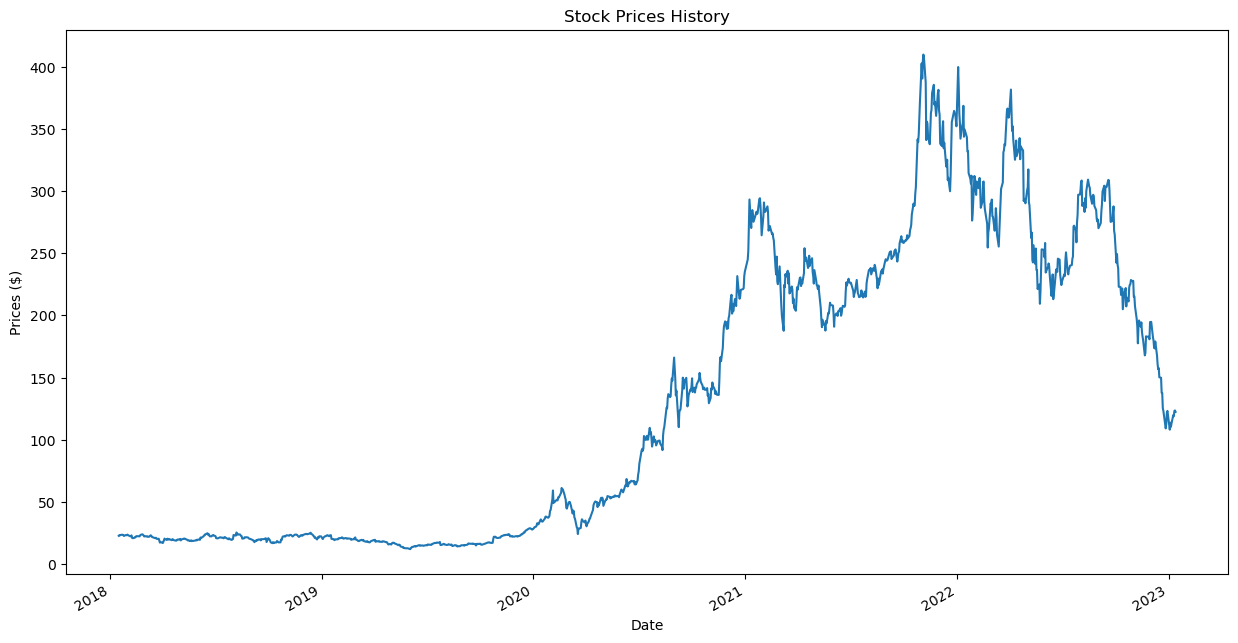

In [95]:
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
data_TSLA['close'].plot()
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [96]:
np.random.seed(12345)

In [128]:
def smape(A, F):
    return 100 / len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))


def metrics(y_true, y_pred):
    print('R2 Score:', r2_score(y_true=y_true, y_pred=y_pred))
    print('RMSE:', mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False))
    print('MAPE:', mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred))
    return r2_score(y_true=y_true, y_pred=y_pred), mean_squared_error(y_true=y_true, y_pred=y_pred,
                                                                      squared=False), mean_absolute_percentage_error(
        y_true=y_true, y_pred=y_pred)

In [130]:
def get_x_y_train_test(feature, test_size, window):
    np.random.seed(12345)
    close_prices = feature
    values = close_prices.values
    training_data_len = math.ceil(len(values) * (1 - test_size))
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(values.reshape(-1, 1))
    train_data = scaled_data[0: training_data_len, :]
    x_train = []
    y_train = []
    for i in range(window, len(train_data)):
        x_train.append(train_data[i - window:i])
        y_train.append(train_data[i])
    x_train, y_train = np.array(x_train), np.array(y_train)
    test_data = scaled_data[training_data_len - window:]
    x_test = []
    y_test = values[training_data_len:]
    for i in range(window, len(test_data)):
        x_test.append(test_data[i - window:i, 0])
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  #TODO способ подачи
    return scaler, x_test, x_train, y_test, y_train

In [139]:
def fit_actions(x_train, y_train, n_features=1):
    np.random.seed(12345)
    model = keras.Sequential()
    model.add(layers.LSTM(100, return_sequences=False, input_shape=(x_train.shape[1], n_features)))
#TODO GPU
    model.add(layers.Dense(1))
    model.summary()
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(x_train, y_train, batch_size=15, epochs=100, verbose=True)
    return model

In [100]:
# smape = round(
#     np.mean(
#         np.abs(predictions - y_test) /
#         ((np.abs(predictions) + np.abs(y_test))/2)
#     )*100, 2
# )
# smape

In [101]:
# tmp = [[[0.58660634],
#         [0.59224231],
#         [0.59349007],
#         [0.88702102],
#         [0.87831163],
#         [0.82000074]]]
# my = model.predict(tmp)
# my

In [102]:
np.random.seed(12345)
scaler_per_day, x_test_per_day, x_train_per_day, y_test_per_day, y_train_per_day = get_x_y_train_test(
    data_TSLA['close'],
    window=60,
    test_size=0.2)
model_per_day = fit_actions(x_train_per_day, y_train_per_day)
predictions_per_day = model_per_day.predict(x_test_per_day)
predictions_per_day = scaler_per_day.inverse_transform(predictions_per_day)
r2_per_day, rmse_per_day, mape_per_day = metrics(y_true=y_test_per_day, y_pred=predictions_per_day)

Model: "sequential_91"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_91 (LSTM)              (None, 100)               40800     
                                                                 
 dense_91 (Dense)            (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
8/8 [==============================] - 0s 11ms/step
R2 Score: 0.968361044128422
RMSE: 10.749140050154205
MAPE: 0.03348841277699327


Метрики посчитаны и записаны, теперь поиграемся с гранулярностью и обучим модель на данных по неделям.

In [103]:
data_TSLA.index

DatetimeIndex(['2018-01-16', '2018-01-17', '2018-01-18', '2018-01-19',
               '2018-01-22', '2018-01-23', '2018-01-24', '2018-01-25',
               '2018-01-26', '2018-01-29',
               ...
               '2022-12-30', '2023-01-03', '2023-01-04', '2023-01-05',
               '2023-01-06', '2023-01-09', '2023-01-10', '2023-01-11',
               '2023-01-12', '2023-01-13'],
              dtype='datetime64[ns]', name='Date', length=1259, freq=None)

In [104]:
first_index = data_TSLA.index[0]
last_index = data_TSLA.index[len(data_TSLA) - 1]
new_data = data_TSLA.loc[first_index:last_index:7, ]
new_data

open        high         low       close   adj close  \
Date                                                                     
2018-01-16   22.502666   23.000000   22.320000   22.670668   22.670668   
2018-01-25   23.218000   23.280001   22.426666   22.509333   22.509333   
2018-02-05   22.531334   22.964666   22.200001   22.208668   22.208668   
2018-02-14   21.389334   21.744667   21.234667   21.487333   21.487333   
2018-02-26   23.566668   23.933332   23.490667   23.827999   23.827999   
...                ...         ...         ...         ...         ...   
2022-11-25  185.059998  185.199997  180.630005  182.860001  182.860001   
2022-12-06  181.220001  183.649994  175.330002  179.820007  179.820007   
2022-12-15  153.440002  160.929993  153.279999  157.669998  157.669998   
2022-12-27  117.500000  119.669998  108.760002  109.099998  109.099998   
2023-01-06  103.000000  114.389999  101.809998  113.059998  113.059998   

               volume  
Date                   
2018-01-16   97114500  
2018-01-25  101104500  
2018-02-05   66961500  
2018-02-14   59260500  
2018-02-26   65100000  
...               ...  
2022-11-25   50672700  
2022-12-06   92150800  
2022-12-15  122334500  
2022-12-27  208643400  
2023-01-06  220575900  

[180 rows x 6 columns]

In [105]:

counter = 0
week = []
column_week = []
column_index = []

for i in range(len(data_TSLA)):
    counter += 1
    if counter > 7:
        counter = 1
        column_week.append(np.mean(week))
        column_index.append(str(data_TSLA.index[i - 7]) + '---' + str(data_TSLA.index[i - 1]))
        week = []
    week.append(data_TSLA.loc[data_TSLA.index[i], 'close'])
#TODO сделать индексы как я хотел (до и после) и обучить модель

data_per_week = pd.DataFrame({'close': column_week}, index=column_index)

display(data_per_week.head(20))
# data_per_week_1 = data.close.rolling(7).mean()


close
2018-01-16 00:00:00---2018-01-24 00:00:00  23.162381
2018-01-25 00:00:00---2018-02-02 00:00:00  23.077619
2018-02-05 00:00:00---2018-02-13 00:00:00  21.687048
2018-02-14 00:00:00---2018-02-23 00:00:00  22.458666
2018-02-26 00:00:00---2018-03-06 00:00:00  22.657809
2018-03-07 00:00:00---2018-03-15 00:00:00  22.172857
2018-03-16 00:00:00---2018-03-26 00:00:00  20.731523
2018-03-27 00:00:00---2018-04-05 00:00:00  18.245333
2018-04-06 00:00:00---2018-04-16 00:00:00  19.811619
2018-04-17 00:00:00---2018-04-25 00:00:00  19.227428
2018-04-26 00:00:00---2018-05-04 00:00:00  19.553048
2018-05-07 00:00:00---2018-05-15 00:00:00  19.941143
2018-05-16 00:00:00---2018-05-24 00:00:00  18.707238
2018-05-25 00:00:00---2018-06-05 00:00:00  19.226191
2018-06-06 00:00:00---2018-06-14 00:00:00  22.196381
2018-06-15 00:00:00---2018-06-25 00:00:00  23.408762
2018-06-26 00:00:00---2018-07-05 00:00:00  22.233047
2018-07-06 00:00:00---2018-07-16 00:00:00  21.090666
2018-07-17 00:00:00---2018-07-25 00:00:00  20.854476
2018-07-26 00:00:00---2018-08-03 00:00:00  20.863714

Теперь обучим на неделях. Передадим в *get_x_y_train_test* признак, где собранны данные по неделям. Протестируем также на неделях.

In [106]:
scaler_per_week, x_test_per_week, x_train_per_week, y_test_per_week, y_train_per_week = get_x_y_train_test(
    data_per_week['close'], window=20, test_size=0.2)
model_per_week = fit_actions(x_train_per_week, y_train_per_week)
predictions_per_week = model_per_week.predict(x_test_per_week)
predictions_per_week = scaler_per_week.inverse_transform(predictions_per_week)

r2_per_week, rmse_per_week, mape_per_week = metrics(y_true=y_test_per_week, y_pred=predictions_per_week)


Model: "sequential_92"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_92 (LSTM)              (None, 100)               40800     
                                                                 
 dense_92 (Dense)            (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
2/2 [==============================] - 0s 3ms/step
R2 Score: 0.636121594562405
RMSE: 33.979945106382786
MAPE: 0.1223276820999428


Теперь же протестируем данные по дням на нашей модели, которую обучали на недельных данных.

In [107]:
predictions_per_week_on_day = model_per_week.predict(x_test_per_day)
predictions_per_week_on_day = scaler_per_week.inverse_transform(predictions_per_week_on_day)
r2_per_week_on_day, rmse_per_week_on_day, mape_per_week_on_day = metrics(y_true=y_test_per_day,
                                                                         y_pred=predictions_per_week_on_day)

8/8 [==============================] - 0s 10ms/step
R2 Score: 0.9034401717507867
RMSE: 18.778499730635147
MAPE: 0.05884878710139475


Получилось, что в не зависимости на какой грануляции мы обучаем модель подавать на вход по дням дает намного больше точности.

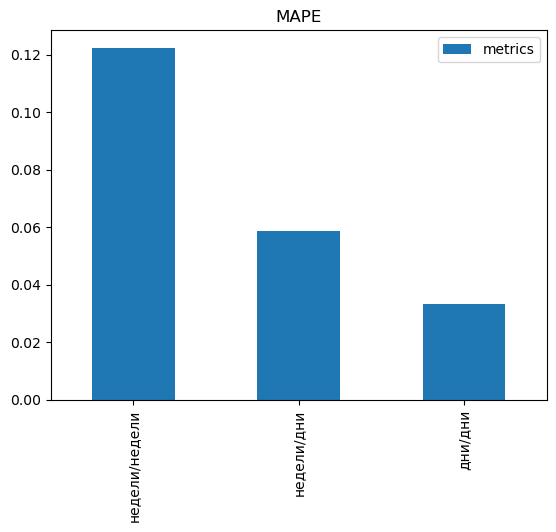

In [115]:
metrics_bar = pd.DataFrame({'metrics': [mape_per_week, mape_per_week_on_day, mape_per_day]},
                           index=['недели/недели', 'недели/дни', 'дни/дни'])
metrics_bar.plot(kind='bar');
plt.title('MAPE');

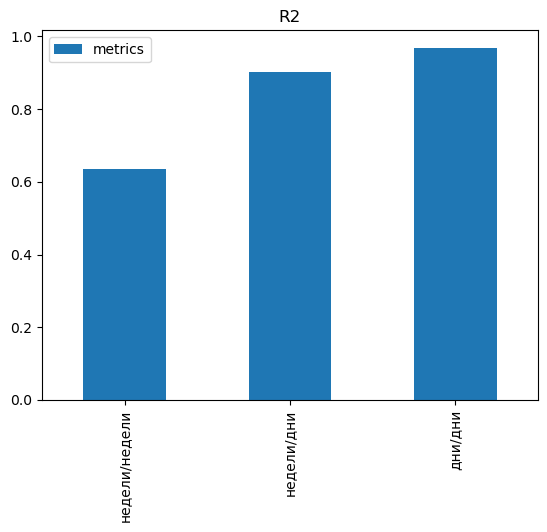

In [117]:
metrics_bar_r2 = pd.DataFrame({'metrics': [r2_per_week, r2_per_week_on_day, r2_per_day]},
                           index=['недели/недели', 'недели/дни', 'дни/дни'])
metrics_bar_r2.plot(kind='bar');
plt.title('R2');

Проведем эксперимент: Часто бывает такое, что на условном начале периода цена акций была в районе 20, как в случае с нашим датасетом, а в конце выборки около 180, то бишь цены намного сильно выросли. Найдем такую точку в датасете, где наблюдается сильная разница между акциями до и после и будем обучать на более "высоких" или же более "низких" ценах, чтобы точнее предсказать следующие дни.

In [205]:
data_TSLA.tail(100)

open        high         low       close   adj close  \
Date                                                                     
2022-08-23  291.453339  298.826660  287.923340  296.453339  296.453339   
2022-08-24  297.563324  303.646667  296.500000  297.096680  297.096680   
2022-08-25  302.359985  302.959991  291.600006  296.070007  296.070007   
2022-08-26  297.429993  302.000000  287.470001  288.089996  288.089996   
2022-08-29  282.829987  287.739990  280.700012  284.820007  284.820007   
...                ...         ...         ...         ...         ...   
2023-01-09  118.959999  123.519997  117.110001  119.769997  119.769997   
2023-01-10  121.070000  122.760002  114.919998  118.849998  118.849998   
2023-01-11  122.089996  125.949997  120.510002  123.220001  123.220001   
2023-01-12  122.559998  124.129997  117.000000  123.559998  123.559998   
2023-01-13  116.550003  122.629997  115.599998  122.400002  122.400002   

               volume  
Date                   
2022-08-23   63984900  
2022-08-24   57259800  
2022-08-25   53230000  
2022-08-26   57163900  
2022-08-29   41864700  
...               ...  
2023-01-09  190284000  
2023-01-10  167642500  
2023-01-11  183810800  
2023-01-12  169400900  
2023-01-13  180439300  

[100 rows x 6 columns]

In [206]:
print(len(data_TSLA))
for i in range(len(data_TSLA)):
    print(data_TSLA.loc[data_TSLA.index[len(data_TSLA) - 1 - i], :])

1259
open         1.165500e+02
high         1.226300e+02
low          1.156000e+02
close        1.224000e+02
adj close    1.224000e+02
volume       1.804393e+08
Name: 2023-01-13 00:00:00, dtype: float64
open         1.225600e+02
high         1.241300e+02
low          1.170000e+02
close        1.235600e+02
adj close    1.235600e+02
volume       1.694009e+08
Name: 2023-01-12 00:00:00, dtype: float64
open         1.220900e+02
high         1.259500e+02
low          1.205100e+02
close        1.232200e+02
adj close    1.232200e+02
volume       1.838108e+08
Name: 2023-01-11 00:00:00, dtype: float64
open         1.210700e+02
high         1.227600e+02
low          1.149200e+02
close        1.188500e+02
adj close    1.188500e+02
volume       1.676425e+08
Name: 2023-01-10 00:00:00, dtype: float64
open         1.189600e+02
high         1.235200e+02
low          1.171100e+02
close        1.197700e+02
adj close    1.197700e+02
volume       1.902840e+08
Name: 2023-01-09 00:00:00, dtype: float64
open 

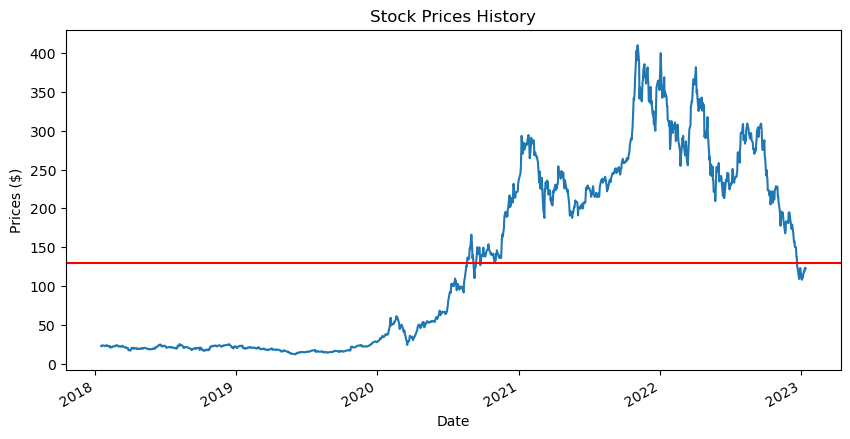

In [207]:
plt.figure(figsize=(10, 5))
plt.title('Stock Prices History')
data_TSLA['close'].plot()
plt.xlabel('Date')
plt.ylabel('Prices ($)');
plt.axhline(130, color='red');

Данных для обучения достаточно.

Кол-во дней для обучения: 583


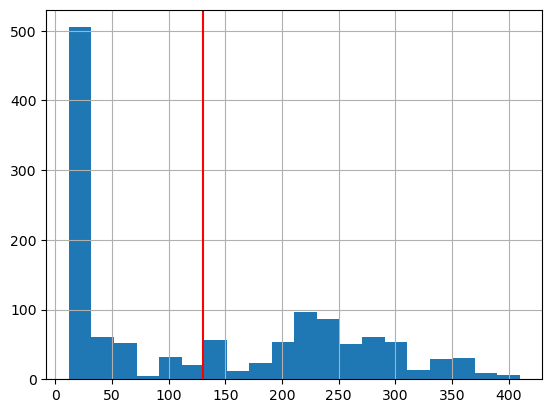

In [209]:
data_TSLA.close.hist(bins=20)
plt.axvline(130, color='red');
print("Кол-во дней для обучения:", len(data_TSLA[data_TSLA['close'] > 130]))

In [210]:
scaler_threshold_TSLA, x_test_threshold_TSLA, x_train_threshold_TSLA, y_test_threshold_TSLA, y_train_threshold_TSLA = get_x_y_train_test(
    data_TSLA.loc['2020-08-20':, 'close'], window=60, test_size=0.2)
model_threshold_TSLA = fit_actions(x_train_threshold_TSLA, y_train_threshold_TSLA)
predictions_threshold_TSLA = model_threshold_TSLA.predict(x_test_threshold_TSLA)
predictions_threshold_TSLA = scaler_threshold_TSLA.inverse_transform(predictions_threshold_TSLA)

Model: "sequential_152"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_145 (LSTM)             (None, 100)               40800     
                                                                 
 dense_145 (Dense)           (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
4/4 [==============================] - 0s 12ms/step


In [211]:
r2_threshold, rmse_threshold, mape_threshold = metrics(y_true=y_test_threshold_TSLA, y_pred=predictions_threshold_TSLA)

R2 Score: 0.9757595741047067
RMSE: 9.777592450791678
MAPE: 0.040893849969980356


Подведем итоги:
- Обучая LSTM на всей выборке по дням и проверяя её на тех же днях метрики выглядят следующим образом:
- - R2 Score: 0.9382207802689864
- - RMSE: 12.518304890459328
- - MAPE: 0.0355177825338899
- Обучая LSTM на всей выборке разбив данные по неделям и проверяя еще на неделях метрики выглядит следующим образом:
- - R2 Score: 0.6477799255148751
- - RMSE: 28.496792117897996
- - MAPE: 0.08916431002672084
- Обучая LSTM на всей выборке разбив данные по неделям и проверяя их на ДНЯХ метрики выглядят следующим образом:
- - R2 Score: 0.8988059441755808
- - RMSE: 16.02144992417443
- - MAPE: 0.04663171922193334
- Обучая LSTM на ЧАСТИЧНОЙ выборке разбив данные по днях и проверяя их на днях метрики выглядят следующим образом:
- - R2 Score: 0.9528368878671135
- - RMSE: 8.898311722896876
- - MAPE: 0.029604843476777658


Таким образом получилось, что лучше всего подавать данные по дням и именно частично, то бишь передавая более свежие данные, которые более точно характеризуют временной отрезок цен акций.

In [122]:
data_APPL = pd.read_csv('../datasets/AAPL.csv', index_col=[0], parse_dates=[0])
data_APPL

Open        High         Low       Close   Adj Close  \
Date                                                                     
2018-01-16   44.474998   44.847500   44.035000   44.047501   41.884754   
2018-01-17   44.037498   44.812500   43.767502   44.775002   42.576534   
2018-01-18   44.842499   45.025002   44.562500   44.814999   42.614574   
2018-01-19   44.652500   44.895000   44.352501   44.615002   42.424400   
2018-01-22   44.325001   44.445000   44.150002   44.250000   42.077309   
...                ...         ...         ...         ...         ...   
2023-01-09  130.470001  133.410004  129.889999  130.149994  130.149994   
2023-01-10  130.259995  131.259995  128.119995  130.729996  130.729996   
2023-01-11  131.250000  133.509995  130.460007  133.490005  133.490005   
2023-01-12  133.880005  134.259995  131.440002  133.410004  133.410004   
2023-01-13  132.029999  134.919998  131.660004  134.759995  134.759995   

               Volume  
Date                   
2018-01-16  118263600  
2018-01-17  137547200  
2018-01-18  124773600  
2018-01-19  129700400  
2018-01-22  108434400  
...               ...  
2023-01-09   70790800  
2023-01-10   63896200  
2023-01-11   69458900  
2023-01-12   71379600  
2023-01-13   57758000  

[1259 rows x 6 columns]

In [123]:
data_APPL.columns = data_APPL.columns.str.lower()
data_APPL.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2018-01-16 to 2023-01-13
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       1259 non-null   float64
 1   high       1259 non-null   float64
 2   low        1259 non-null   float64
 3   close      1259 non-null   float64
 4   adj close  1259 non-null   float64
 5   volume     1259 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.9 KB


Text(0, 0.5, 'Prices ($)')

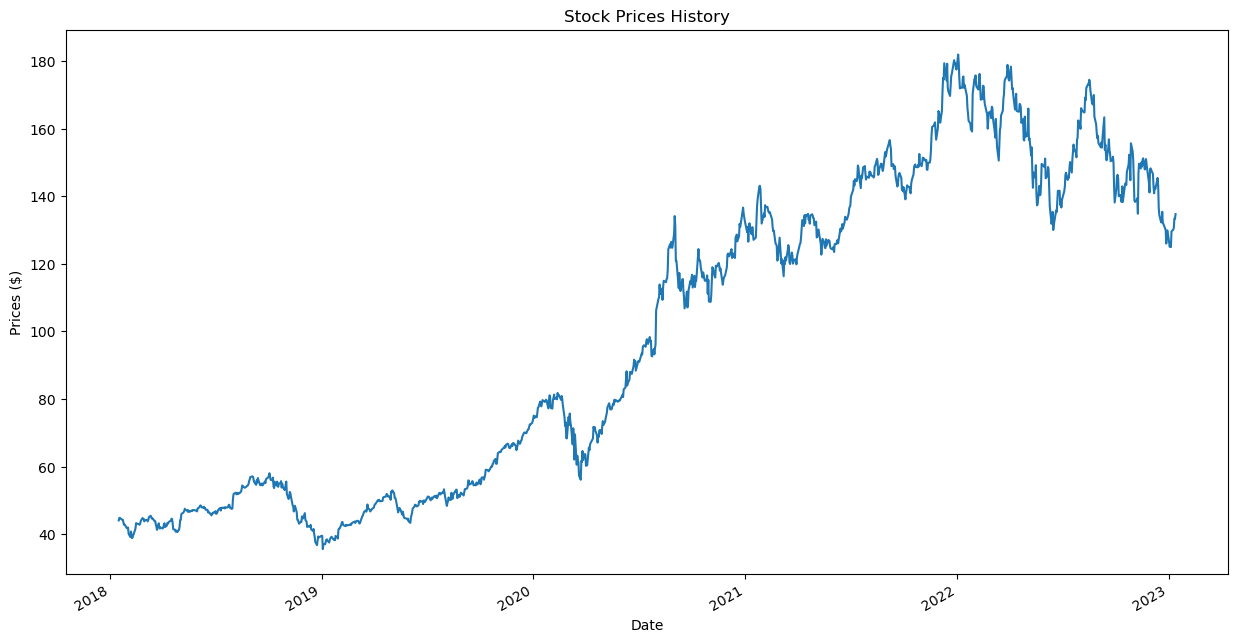

In [124]:
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
data_APPL['close'].plot()
plt.xlabel('Date')
plt.ylabel('Prices ($)')

Иcходя из предыдущий вычислений, обучать будем не на всем датасете, а на частичном.

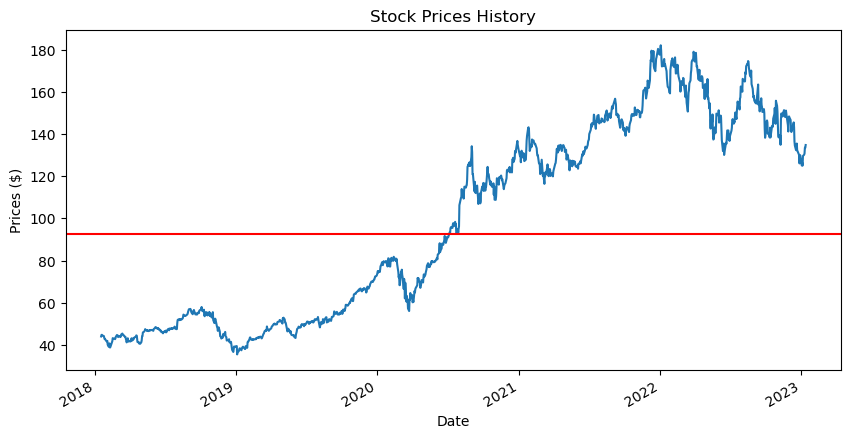

In [215]:
plt.figure(figsize=(10, 5))
plt.title('Stock Prices History')
data_APPL['close'].plot()
plt.xlabel('Date')
plt.ylabel('Prices ($)');
plt.axhline(92.50, color='red');

In [216]:
scaler_threshold_APPL, x_test_threshold_APPL, x_train_threshold_APPL, y_test_threshold_APPL, y_train_threshold_APPL = get_x_y_train_test(
    data_APPL.loc['2020-07-06':, 'close'], window=60, test_size=0.2)
model_threshold_APPL = fit_actions(x_train_threshold_APPL, y_train_threshold_APPL)
predictions_threshold_APPL = model_threshold_APPL.predict(x_test_threshold_APPL)
predictions_threshold_APPL = scaler_threshold_APPL.inverse_transform(predictions_threshold_APPL)

Model: "sequential_153"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_146 (LSTM)             (None, 100)               40800     
                                                                 
 dense_146 (Dense)           (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
4/4 [==============================] - 0s 9ms/step


In [217]:
r2_threshold, rmse_threshold, mape_threshold = metrics(y_true=y_test_threshold_APPL, y_pred=predictions_threshold_APPL)

R2 Score: 0.9202359282382007
RMSE: 3.3384245064660796
MAPE: 0.017579144290273394


In [ ]:
# total_data = pd.concat([data_TSLA.loc['2020-08-20':, 'close']] + [data_TSLA.loc['2020-08-20':, 'close']])
# total_data

In [ ]:
# scaler_threshold_total, x_test_threshold_total, x_train_threshold_total, y_test_threshold_total, y_train_threshold_total = get_x_y_train_test(
#     total_data, window=60, test_size=0.2)
# model_threshold_total = fit_actions(x_train_threshold_total, y_train_threshold_total)
# predictions_threshold_total = model_threshold_total.predict(x_test_threshold_total)
# predictions_threshold_total = scaler_threshold_total.inverse_transform(predictions_threshold_total)

In [ ]:
# r2_threshold, rmse_threshold, mape_threshold = metrics(y_true=y_test_threshold_total, y_pred=predictions_threshold_total)

Теперь попробуем обучить Multivariate LSTM. Добавим к акциям Теслы еще и информацию об акциях Apple. Однако наш предыдущий метод, который позволял нам разбивать данные *get_x_y_train_test*, так как он предназначался для одномерных массивов, а теперь у нас их целых два! Создадим новый метод.

In [125]:
def split_sequence(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps
        if end_ix > len(sequences) - 1:
            break
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix - 1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

И подготовим данные для их дальнейшей передачи в метод.

In [126]:
tesla = data_TSLA['close'].values
apple = data_APPL['close'].values
out_tesla = data_TSLA['close'].shift(-1).values

tesla = tesla.reshape((len(tesla), 1))
apple = apple.reshape((len(apple), 1))
out_tesla = out_tesla.reshape((len(out_tesla), 1))

# print(tesla.shape)
# print(apple.shape)
# print(out_tesla)

dataset = np.hstack((tesla, apple, out_tesla))
pd.DataFrame(dataset)

0           1           2
0      22.670668   44.047501   23.143999
1      23.143999   44.775002   22.971333
2      22.971333   44.814999   23.334667
3      23.334667   44.615002   23.437332
4      23.437332   44.250000   23.519333
...          ...         ...         ...
1254  119.769997  130.149994  118.849998
1255  118.849998  130.729996  123.220001
1256  123.220001  133.490005  123.559998
1257  123.559998  133.410004  122.400002
1258  122.400002  134.759995         NaN

[1259 rows x 3 columns]

Укажем временное окно и посмотрим как теперь выглядят наши данные. Можем заметить, что действительно - 60 дней теслы и 60 дней эппл теперь указывают на 61 день теслы.

In [127]:
n_steps = 60
X, y = split_sequence(dataset, n_steps)
n_features = X.shape[2]
#TODO global model одну для разных компаний.
for i in range(len(X)):
    print(X[i], y[i])

[[22.670668 44.047501]
 [23.143999 44.775002]
 [22.971333 44.814999]
 [23.334667 44.615002]
 [23.437332 44.25    ]
 [23.519333 44.259998]
 [23.059334 43.555   ]
 [22.509333 42.7775  ]
 [22.856667 42.877499]
 [23.302    41.990002]
 [23.054667 41.7425  ]
 [23.620667 41.857498]
 [23.283333 41.945   ]
 [22.916668 40.125   ]
 [22.208668 39.122501]
 [22.264668 40.7575  ]
 [23.       39.884998]
 [21.015333 38.787498]
 [20.694668 39.102501]
 [21.048668 40.677502]
 [21.577333 41.084999]
 [21.487333 41.842499]
 [22.271334 43.247501]
 [22.365999 43.107498]
 [22.318001 42.962502]
 [22.219999 42.767502]
 [23.077999 43.125   ]
 [23.469999 43.875   ]
 [23.827999 44.7425  ]
 [23.399332 44.5975  ]
 [22.870667 44.529999]
 [22.062    43.75    ]
 [22.341333 44.052502]
 [22.223333 44.205002]
 [21.879999 44.1675  ]
 [22.153334 43.7575  ]
 [21.940001 44.235001]
 [21.811333 44.994999]
 [23.034    45.43    ]
 [22.789333 44.9925  ]
 [21.775333 44.610001]
 [21.706667 44.662498]
 [21.423332 44.505001]
 [20.903999

In [128]:
X.shape

(1199, 60, 2)

In [129]:
train_size = int(np.ceil(0.8 * len(X)))
test_size = int(len(X) - train_size)

features_train = X[:train_size]
target_train = y[:train_size]
features_test = X[test_size:]
target_test = y[test_size:]
target_train

array([ 19.605333,  20.022667,  19.414   ,  19.179333,  19.556667,
        20.005333,  19.349333,  18.891333,  18.897333,  18.712667,
        19.032   ,  19.605333,  19.593332,  19.994667,  20.076668,
        18.963333,  19.606001,  20.184668,  20.131332,  20.456667,
        20.334667,  20.070667,  19.464666,  18.945333,  19.098667,
        18.969334,  18.454666,  18.966   ,  18.334   ,  18.604668,
        18.523333,  18.59    ,  18.917334,  19.448   ,  18.982   ,
        19.454666,  19.782667,  19.408667,  21.299999,  21.072666,
        21.177334,  22.139999,  22.851334,  22.985332,  23.848   ,
        23.878   ,  24.722   ,  23.503332,  24.148001,  23.167334,
        22.242001,  22.200666,  22.799999,  22.966667,  23.328667,
        22.863333,  22.337999,  20.724001,  20.610666,  20.593332,
        21.233999,  21.497999,  21.264   ,  21.114   ,  21.257999,
        20.673332,  21.512667,  21.59    ,  21.348667,  20.905333,
        20.213333,  19.828667,  20.582666,  20.443333,  19.812

In [130]:
model_per_day = fit_actions(features_train, target_train, n_features)
predictions_per_day = model_per_day.predict(features_test)
# predictions_per_day = scaler.inverse_transform(predictions_per_day)
r2_per_day1, rmse_per_day1, mape_per_day1 = metrics(y_true=target_test, y_pred=predictions_per_day)

Model: "sequential_93"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_93 (LSTM)              (None, 100)               41200     
                                                                 
 dense_93 (Dense)            (None, 1)                 101       
                                                                 
Total params: 41,301
Trainable params: 41,301
Non-trainable params: 0
_________________________________________________________________
30/30 [==============================] - 1s 11ms/step
R2 Score: 0.9780961682229286
RMSE: 16.876693158671824
MAPE: 0.04364975363594762


R2 Score: 0.9679804522525206
RMSE: 10.813598653815808
MAPE: 0.03424645931778173
<b></b>
Это метрики обучения модели по дням Теслы. Можно заметить, что незначительно улучшился R2 score, а остальные стали хуже. Но не стоит забывать, что это практически никак не связанные компании, так что это была просто проверка LSTM на факт умения обращаться с двумя и более признаками для предсказания и она успешно справилась!

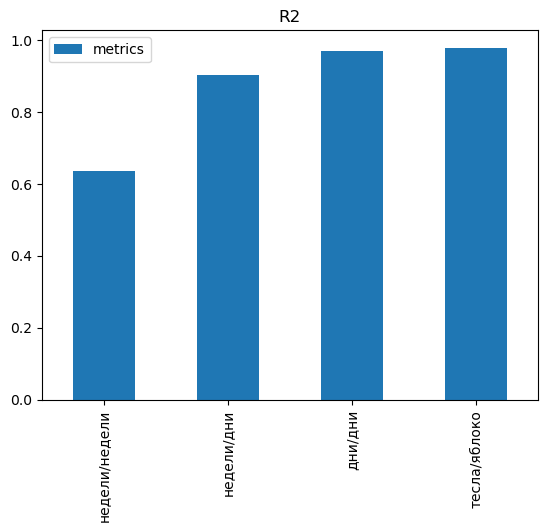

In [131]:
metrics_bar_r2 = pd.DataFrame({'metrics': [r2_per_week, r2_per_week_on_day, r2_per_day, r2_per_day1]},
                              index=['недели/недели', 'недели/дни', 'дни/дни', 'тесла/яблоко'])
metrics_bar_r2.plot(kind='bar');
plt.title('R2');

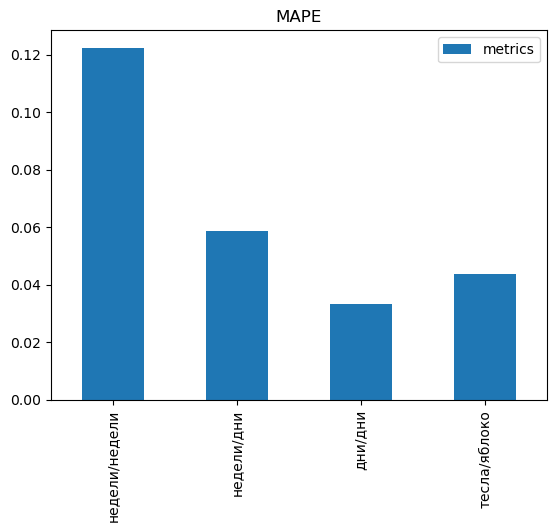

In [132]:
metrics_bar_r2 = pd.DataFrame({'metrics': [mape_per_week, mape_per_week_on_day, mape_per_day, mape_per_day1]},
                              index=['недели/недели', 'недели/дни', 'дни/дни', 'тесла/яблоко'])
metrics_bar_r2.plot(kind='bar');
plt.title('MAPE');

In [288]:
def sorocinTest(data, feature, window):
    needed_value = data[len(data) - window:][feature].median()
    print('need:', needed_value)
    closest_value = needed_value + 1
    closest_year = 0
    for year in np.unique(data.index.year)[0:len(np.unique(data.index.year)) - 2]:
        if abs(needed_value - data.loc[f'{year}-01-01':f'{year}-12-30', feature].median()) < closest_value:
            closest_year = year
            closest_value = abs(needed_value - data.loc[f'{year}-01-01':f'{year}-12-30', feature].median())
        print(f'Медиана за {year} год:', data.loc[f'{year}-01-01':f'{year}-12-30', feature].median())
        print()
    return closest_year

In [289]:
sorocinTest(data_TSLA, 'close', 60)

need: 180.00500449999998
Медиана за 2018 год: 21.177334

Медиана за 2019 год: 17.344667

Медиана за 2020 год: 77.609665

Медиана за 2021 год: 243.256668



2021

In [290]:
for year in np.unique(data_TSLA.index.year):
    iter_data = data_TSLA[f'{year}-01-01':]
    iter_data = iter_data['close']
    scaler_per_day, x_test_per_day, x_train_per_day, y_test_per_day, y_train_per_day = get_x_y_train_test(iter_data,
                                                                                                          window=60,
                                                                                                          test_size=0.1)

    model_per_day = fit_actions(x_train_per_day, y_train_per_day)
    predictions_per_day = model_per_day.predict(x_test_per_day)
    predictions_per_day = scaler_per_day.inverse_transform(predictions_per_day)
    print(year, 'ГОД')
    display(metrics(y_true=y_test_per_day, y_pred=predictions_per_day))

Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_61 (LSTM)              (None, 100)               40800     
                                                                 
 dense_61 (Dense)            (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
72/72 [==============================] - 3s 19ms/step - loss: 0.0148
Epoch 2/100
72/72 [==============================] - 1s 19ms/step - loss: 0.0013
Epoch 3/100
72/72 [==============================] - 1s 19ms/step - loss: 0.0013
Epoch 4/100
72/72 [==============================] - 1s 20ms/step - loss: 0.0011
Epoch 5/100
72/72 [==============================] - 1s 19ms/step - loss: 0.0011
Epoch 6/100
72/72 [=====================

(0.9808428693884789, 8.598679460280247, 0.03188947830661355)

Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_62 (LSTM)              (None, 100)               40800     
                                                                 
 dense_62 (Dense)            (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
58/58 [==============================] - 2s 19ms/step - loss: 0.0223
Epoch 2/100
58/58 [==============================] - 1s 20ms/step - loss: 0.0016
Epoch 3/100
58/58 [==============================] - 1s 20ms/step - loss: 0.0015
Epoch 4/100
58/58 [==============================] - 1s 20ms/step - loss: 0.0015
Epoch 5/100
58/58 [==============================] - 1s 20ms/step - loss: 0.0014
Epoch 6/100
58/58 [=====================

(0.9809988951819131, 8.261923507628032, 0.033416027334076115)

Model: "sequential_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_63 (LSTM)              (None, 100)               40800     
                                                                 
 dense_63 (Dense)            (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
42/42 [==============================] - 2s 19ms/step - loss: 0.0308
Epoch 2/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0027
Epoch 3/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0022
Epoch 4/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0021
Epoch 5/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0021
Epoch 6/100
42/42 [=====================

(0.9573845006654385, 9.200906320704847, 0.04059341265474935)

Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_64 (LSTM)              (None, 100)               40800     
                                                                 
 dense_64 (Dense)            (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
27/27 [==============================] - 2s 20ms/step - loss: 0.0398
Epoch 2/100
27/27 [==============================] - 1s 20ms/step - loss: 0.0062
Epoch 3/100
27/27 [==============================] - 1s 20ms/step - loss: 0.0051
Epoch 4/100
27/27 [==============================] - 1s 20ms/step - loss: 0.0047
Epoch 5/100
27/27 [==============================] - 1s 19ms/step - loss: 0.0042
Epoch 6/100
27/27 [=====================

(0.9374719091726859, 8.373558114213992, 0.04459363431872387)

Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_65 (LSTM)              (None, 100)               40800     
                                                                 
 dense_65 (Dense)            (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
12/12 [==============================] - 1s 19ms/step - loss: 0.1133
Epoch 2/100
12/12 [==============================] - 0s 18ms/step - loss: 0.0120
Epoch 3/100
12/12 [==============================] - 0s 18ms/step - loss: 0.0062
Epoch 4/100
12/12 [==============================] - 0s 19ms/step - loss: 0.0056
Epoch 5/100
12/12 [==============================] - 0s 18ms/step - loss: 0.0048
Epoch 6/100
12/12 [=====================

(0.4681517800681887, 16.34105626329169, 0.10970163587328186)

IndexError: tuple index out of range

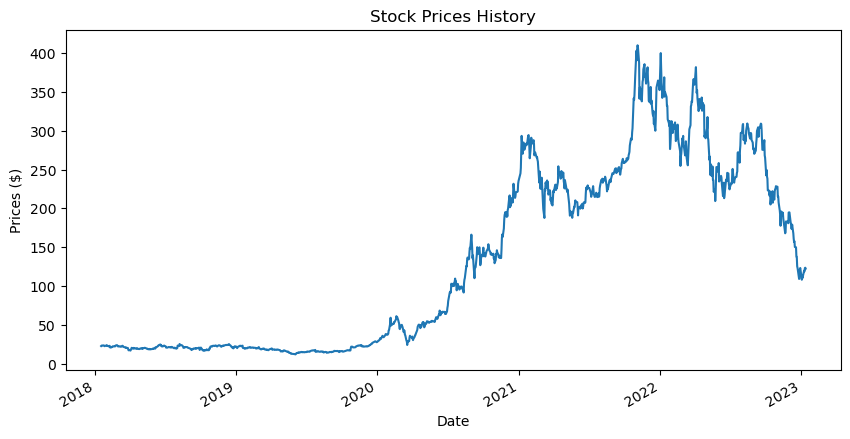

In [247]:
plt.figure(figsize=(10, 5))
plt.title('Stock Prices History')
data_TSLA['close'].plot()
plt.xlabel('Date')  #TODO посмотреть на фиксированый тест сайз
plt.ylabel('Prices ($)');

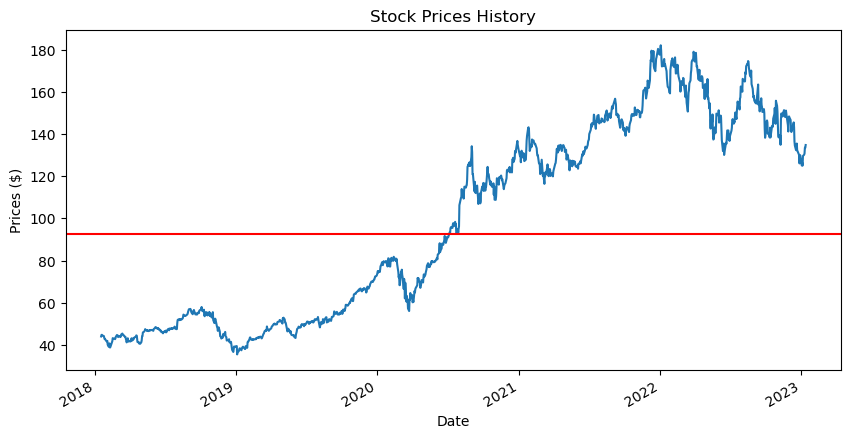

In [248]:
plt.figure(figsize=(10, 5))
plt.title('Stock Prices History')
data_APPL['close'].plot()
plt.xlabel('Date')
plt.ylabel('Prices ($)');

In [270]:
sorocinTest(data_APPL, 'close', 60)

need: 143.0600055
Медиана за 2018 год: 46.717499

Медиана за 2019 год: 50.724998

Медиана за 2020 год: 91.42124949999999

Медиана за 2021 год: 141.110001



2021

In [291]:
for year in np.unique(data_APPL.index.year):
    iter_data = data_APPL[f'{year}-01-01':]
    iter_data = iter_data['close']
    scaler_per_day, x_test_per_day, x_train_per_day, y_test_per_day, y_train_per_day = get_x_y_train_test(iter_data,
                                                                                                          window=60,
                                                                                                          test_size=0.1)  #TODO test size za месяц

    model_per_day = fit_actions(x_train_per_day, y_train_per_day)
    predictions_per_day = model_per_day.predict(x_test_per_day)
    predictions_per_day = scaler_per_day.inverse_transform(predictions_per_day)
    print(year, 'ГОД')
    display(metrics(y_true=y_test_per_day, y_pred=predictions_per_day))
#TODO рассказать идею - чем больше данных тем, чем меньше данных тем RMSE, а раньше думал, чем свежее данные

Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_66 (LSTM)              (None, 100)               40800     
                                                                 
 dense_66 (Dense)            (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
72/72 [==============================] - 3s 21ms/step - loss: 0.0231
Epoch 2/100
72/72 [==============================] - 1s 21ms/step - loss: 9.0629e-04
Epoch 3/100
72/72 [==============================] - 1s 20ms/step - loss: 8.3432e-04
Epoch 4/100
72/72 [==============================] - 1s 21ms/step - loss: 8.0048e-04
Epoch 5/100
72/72 [==============================] - 1s 20ms/step - loss: 7.6198e-04
Epoch 6/100
72/72 [=====

(0.9226720868373776, 3.3127720357930697, 0.01700225256391687)

Model: "sequential_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_67 (LSTM)              (None, 100)               40800     
                                                                 
 dense_67 (Dense)            (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
58/58 [==============================] - 2s 20ms/step - loss: 0.0182
Epoch 2/100
58/58 [==============================] - 1s 22ms/step - loss: 0.0010
Epoch 3/100
58/58 [==============================] - 1s 20ms/step - loss: 9.9378e-04
Epoch 4/100
58/58 [==============================] - 1s 20ms/step - loss: 0.0010
Epoch 5/100
58/58 [==============================] - 1s 20ms/step - loss: 8.2373e-04
Epoch 6/100
58/58 [=============

(0.8864628396715508, 3.385866313306692, 0.017856032372171773)

Model: "sequential_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_68 (LSTM)              (None, 100)               40800     
                                                                 
 dense_68 (Dense)            (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
42/42 [==============================] - 2s 20ms/step - loss: 0.0362
Epoch 2/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0023
Epoch 3/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0016
Epoch 4/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0017
Epoch 5/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0016
Epoch 6/100
42/42 [=====================

(0.7842993617153156, 3.5429413790676305, 0.019440537661621744)

Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_69 (LSTM)              (None, 100)               40800     
                                                                 
 dense_69 (Dense)            (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
27/27 [==============================] - 2s 19ms/step - loss: 0.0459
Epoch 2/100
27/27 [==============================] - 1s 19ms/step - loss: 0.0068
Epoch 3/100
27/27 [==============================] - 1s 20ms/step - loss: 0.0055
Epoch 4/100
27/27 [==============================] - 1s 19ms/step - loss: 0.0051
Epoch 5/100
27/27 [==============================] - 1s 20ms/step - loss: 0.0049
Epoch 6/100
27/27 [=====================

(0.7934324275824888, 3.678377201709779, 0.020071178976931718)

Model: "sequential_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_70 (LSTM)              (None, 100)               40800     
                                                                 
 dense_70 (Dense)            (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
12/12 [==============================] - 1s 21ms/step - loss: 0.1198
Epoch 2/100
12/12 [==============================] - 0s 20ms/step - loss: 0.0162
Epoch 3/100
12/12 [==============================] - 0s 20ms/step - loss: 0.0120
Epoch 4/100
12/12 [==============================] - 0s 20ms/step - loss: 0.0110
Epoch 5/100
12/12 [==============================] - 0s 20ms/step - loss: 0.0100
Epoch 6/100
12/12 [=====================

(0.2518137101077317, 5.1348077797365725, 0.032008364813420356)

IndexError: tuple index out of range

In [ ]:
print('Средняя за весь период:', data_TSLA['close'].mean())
print()

for year in np.unique(data_APPL.index.year):
    print(f'Медиана за {year} год:', data_APPL.loc[f'{year}-01-01':f'{year}-12-30', 'close'].median())
    print(f'В первый день {year}:', data_APPL.loc[f'{year}-01-01':, 'close'][0])
    print()
# data_TSLA.loc[f'{data_TSLA.index[len(data_TSLA.index) - 1]}', 'close']
data_APPL[len(data_APPL) - 60:]['close'].median()

In [296]:
data_META = pd.read_csv('../datasets/META.csv', index_col=[0], parse_dates=[0])
data_META.columns = data_META.columns.str.lower()

Text(0, 0.5, 'Prices ($)')

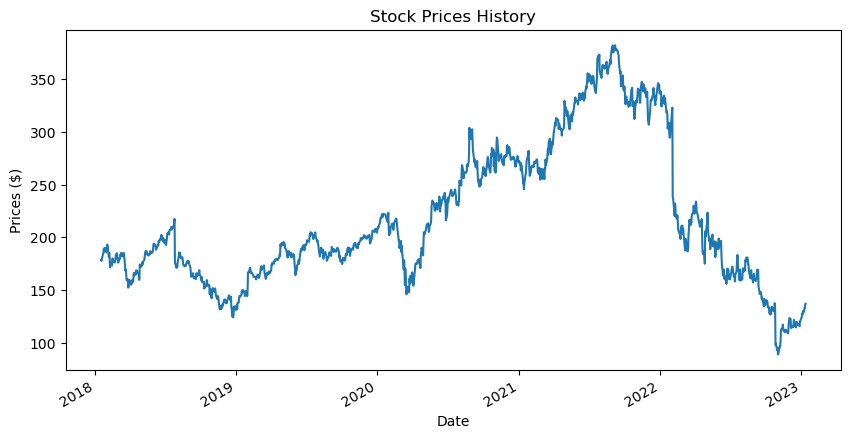

In [297]:
plt.figure(figsize=(10, 5))
plt.title('Stock Prices History')
data_META['close'].plot()
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [ ]:
sorocinTest(data_META, 'close', 60)

In [ ]:
for year in np.unique(data_META.index.year):
    iter_data = data_META[f'{year}-01-01':]
    iter_data = iter_data['close']
    scaler_per_day, x_test_per_day, x_train_per_day, y_test_per_day, y_train_per_day = get_x_y_train_test(iter_data,
                                                                                                          window=60,
                                                                                                          test_size=0.2)

    model_per_day = fit_actions(x_train_per_day, y_train_per_day)
    predictions_per_day = model_per_day.predict(x_test_per_day)
    predictions_per_day = scaler_per_day.inverse_transform(predictions_per_day)
    print(year, 'ГОД')
    display(metrics(y_true=y_test_per_day, y_pred=predictions_per_day))


In [294]:
data_GOOG = pd.read_csv('../datasets/GOOG.csv', index_col=[0], parse_dates=[0])
data_GOOG.columns = data_GOOG.columns.str.lower()

Text(0, 0.5, 'Prices ($)')

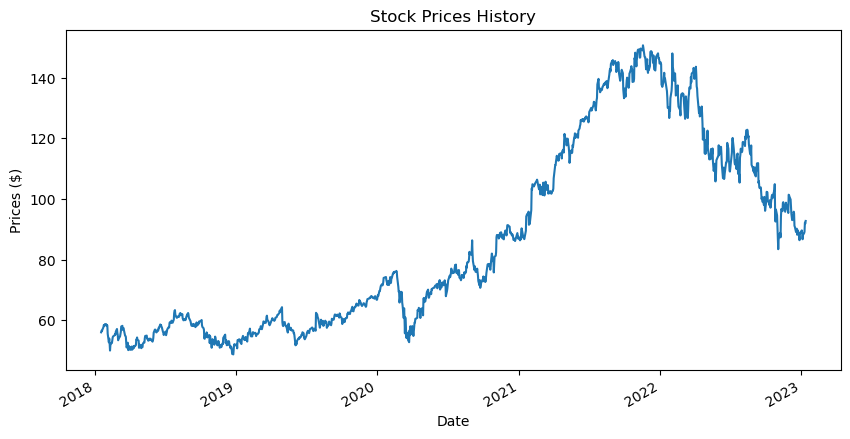

In [295]:
plt.figure(figsize=(10, 5))
plt.title('Stock Prices History')
data_GOOG['close'].plot()
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [ ]:
sorocinTest(data_GOOG, 'close', 100)

In [ ]:
for year in np.unique(data_GOOG.index.year):
    iter_data = data_GOOG[f'{year}-01-01':]
    iter_data = iter_data['close']
    scaler_per_day, x_test_per_day, x_train_per_day, y_test_per_day, y_train_per_day = get_x_y_train_test(iter_data,
                                                                                                          window=60,
                                                                                                          test_size=0.2)

    model_per_day = fit_actions(x_train_per_day, y_train_per_day)
    predictions_per_day = model_per_day.predict(x_test_per_day)
    predictions_per_day = scaler_per_day.inverse_transform(predictions_per_day)
    print(year, 'ГОД')
    display(metrics(y_true=y_test_per_day, y_pred=predictions_per_day))


In [ ]:
iter_data = data_GOOG['2019-01-01':]
iter_data = iter_data['close']
scaler_per_day, x_test_per_day, x_train_per_day, y_test_per_day, y_train_per_day = get_x_y_train_test(iter_data,
                                                                                                      window=60,
                                                                                                      test_size=0.2)

model_per_day = fit_actions(x_train_per_day, y_train_per_day)
predictions_per_day = model_per_day.predict(x_test_per_day)
predictions_per_day = scaler_per_day.inverse_transform(predictions_per_day)
display(metrics(y_true=y_test_per_day, y_pred=predictions_per_day))

In [ ]:
data_NFLX = pd.read_csv('../datasets/NFLX.csv', index_col=[0], parse_dates=[0])
data_NFLX.columns = data_NFLX.columns.str.lower()

In [ ]:
plt.figure(figsize=(10, 5))
plt.title('Stock Prices History')
data_NFLX['close'].plot()
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [ ]:
sorocinTest(data_NFLX, 'close', 60)

In [ ]:
for year in np.unique(data_GOOG.index.year):
    iter_data = data_GOOG[f'{year}-01-01':]
    iter_data = iter_data['close']
    scaler_per_day, x_test_per_day, x_train_per_day, y_test_per_day, y_train_per_day = get_x_y_train_test(iter_data,
                                                                                                          window=60,
                                                                                                          test_size=0.2)

    model_per_day = fit_actions(x_train_per_day, y_train_per_day)
    predictions_per_day = model_per_day.predict(x_test_per_day)
    predictions_per_day = scaler_per_day.inverse_transform(predictions_per_day)
    print(year, 'ГОД')
    display(metrics(y_true=y_test_per_day, y_pred=predictions_per_day))


In [2]:
def split_sequence_new(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence) - 1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [60]:
data_TSLA_10_years = pd.read_csv('../datasets_10_years/TSLA-10.csv', index_col=[0], parse_dates=[0])
data_TSLA_10_years.columns = data_TSLA_10_years.columns.str.lower()

Text(0, 0.5, 'Prices ($)')

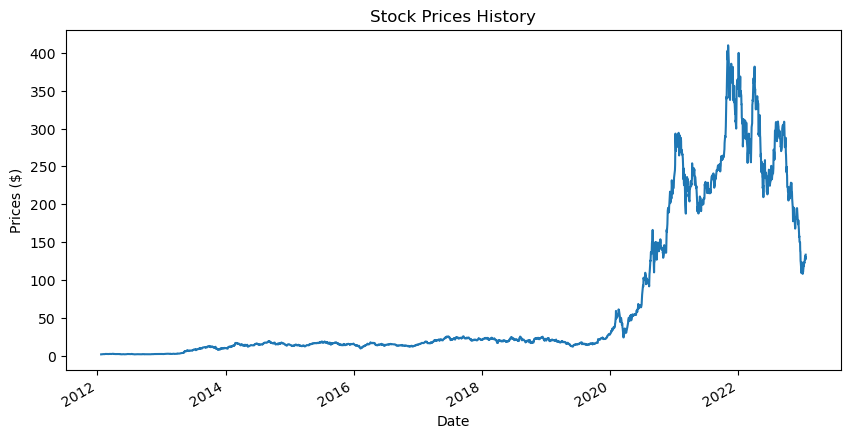

In [61]:
plt.figure(figsize=(10, 5))
plt.title('Stock Prices History')
data_TSLA_10_years['close'].plot()
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [62]:
n_steps = 60
X, y = split_sequence_new(data_TSLA_10_years['close'], n_steps)
data_TSLA_10_years['close'].shape

(2768,)

In [63]:
train_size = len(X) - 30
test_size = 30
print(train_size)
print(test_size)

features_train = X[:train_size]
target_train = y[:train_size]
features_test = X[len(X) - 30:]
target_test = y[len(X) - 30:]
print(features_train.shape)
print(features_test.shape)

2678
30
(2678, 60)
(30, 60)


In [64]:
model_per_day = fit_actions(features_train, target_train)
predictions_per_day = model_per_day.predict(features_test)
r2_per_day, rmse_per_day, mape_per_day = metrics(y_true=target_test, y_pred=predictions_per_day)

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 100)               40800     
                                                                 
 dense_21 (Dense)            (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
179/179 [==============================] - 5s 18ms/step - loss: 12982.4229
Epoch 2/100
179/179 [==============================] - 3s 18ms/step - loss: 10552.2412
Epoch 3/100
179/179 [==============================] - 3s 18ms/step - loss: 9088.7842
Epoch 4/100
179/179 [==============================] - 3s 18ms/step - loss: 7877.1499
Epoch 5/100
179/179 [==============================] - 3s 18ms/step - loss: 6830.9609
Epoch 6/100
1

In [33]:

for year in np.unique(data_TSLA_10_years.index.year):
    iter_data = data_TSLA_10_years[f'{year}-01-01':]
    iter_data = iter_data['close']
    n_steps = 60
    X, y = split_sequence_new(iter_data, n_steps)

    train_size = len(X) - 30
    test_size = 30

    # scaler = MinMaxScaler(feature_range=(0, 1))
    # scaler.fit(features_train)

    features_train = X[:train_size]
    target_train = y[:train_size]
    features_test = X[len(X) - 30:]
    target_test = y[len(X) - 30:]

    # features_train = scaler.transform(features_train)
    # features_test = scaler.transform(features_test)

    model_per_day = fit_actions(features_train, target_train)
    predictions_per_day = model_per_day.predict(features_test)
    print('ГОД:', year)
    r2_per_day, rmse_per_day, mape_per_day = metrics(y_true=target_test, y_pred=predictions_per_day)


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 100)               40800     
                                                                 
 dense_11 (Dense)            (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


KeyboardInterrupt: 

In [55]:
models_dict = {}

models_dict['TSLA'] = {}
models_dict['AAPL'] = {}
models_dict['META'] = {}
models_dict['GOOG'] = {}
models_dict['NFLX'] = {}
models_dict['NVDA'] = {}
models_dict['MU'] = {}

In [3]:
def fitting_per_year(company, key):
    total_start = time.time()
    best_r2 = 0
    best_rmse = 1000000
    best_mape = 1000

    best_year_r2 = 0
    best_year_rmse = 0
    best_year_mape = 0
    for year in np.unique(company.index.year)[0:len(np.unique(company.index.year)) - 1]:
        start = time.time()
        iter_data = company[f'{year}-01-01':]
        iter_data = iter_data['close']
        n_steps = 60
        X, y = split_sequence_new(iter_data, n_steps)

        train_size = len(X) - 60
        test_size = 60

        # scaler = MinMaxScaler(feature_range=(0, 1))
        # scaler.fit(features_train)

        features_train = X[:train_size]
        target_train = y[:train_size]
        features_test = X[len(X) - 60:]
        target_test = y[len(X) - 60:]

        # features_train = scaler.transform(features_train)
        # features_test = scaler.transform(features_test)

        model_per_day = fit_actions(features_train, target_train)
        predictions_per_day = model_per_day.predict(features_test)
        print('ГОД:', year)
        r2, rmse, mape = metrics(y_true=target_test, y_pred=predictions_per_day)

        if r2 > best_r2:
            best_r2 = r2
            best_year_r2 = year
        if best_rmse > rmse:
            best_rmse = rmse
            best_year_rmse = year
        if best_mape > mape:
            best_mape = mape
            best_year_mape = year
        end = time.time() - start
        models_dict[key][year] = {'model': model_per_day, 'r2': r2, 'rmse': rmse, 'mape': mape, 'time': end}
    total_end = time.time() - total_start
    models_dict[key]['total_time'] = total_end
    models_dict[key]['best_result'] = {'best_r2': best_r2, 'best_rmse': best_rmse, 'best_mape': best_mape}
    models_dict[key]['best_years'] = {'best_year_r2': best_year_r2, 'best_year_rmse': best_year_rmse,
                                      'best_year_mape': best_year_mape}



In [57]:
data_AAPL_10_years = pd.read_csv('../datasets_10_years/AAPL-10.csv', index_col=[0], parse_dates=[0])
data_AAPL_10_years.columns = data_AAPL_10_years.columns.str.lower()

In [58]:
data_GOOG_10_years = pd.read_csv('../datasets_10_years/GOOG-10.csv', index_col=[0], parse_dates=[0])
data_GOOG_10_years.columns = data_GOOG_10_years.columns.str.lower()

In [59]:
data_META_10_years = pd.read_csv('../datasets_10_years/META-10.csv', index_col=[0], parse_dates=[0])
data_META_10_years.columns = data_META_10_years.columns.str.lower()

In [60]:
data_NFLX_10_years = pd.read_csv('../datasets_10_years/NFLX-10.csv', index_col=[0], parse_dates=[0])
data_NFLX_10_years.columns = data_NFLX_10_years.columns.str.lower()

In [61]:
data_TSLA_10_years = pd.read_csv('../datasets_10_years/TSLA-10.csv', index_col=[0], parse_dates=[0])
data_TSLA_10_years.columns = data_TSLA_10_years.columns.str.lower()

In [62]:
data_NVDA_10_years = pd.read_csv('../datasets_10_years/NVDA-10.csv', index_col=[0], parse_dates=[0])
data_NVDA_10_years.columns = data_NVDA_10_years.columns.str.lower()

In [63]:
data_MU_10_years = pd.read_csv('../datasets_10_years/MU-10.csv', index_col=[0], parse_dates=[0])
data_MU_10_years.columns = data_MU_10_years.columns.str.lower()

In [64]:
fitting_per_year(data_TSLA_10_years, 'TSLA')

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 100)               40800     
                                                                 
 dense_14 (Dense)            (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
2/2 [==============================] - 0s 10ms/step
ГОД: 2012
R2 Score: 0.8270298877619727
RMSE: 15.261887581171454
MAPE: 0.08259864129125806
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 100)               40800     
                                                                 
 dense_15 (Dense

Text(0, 0.5, 'Prices ($)')

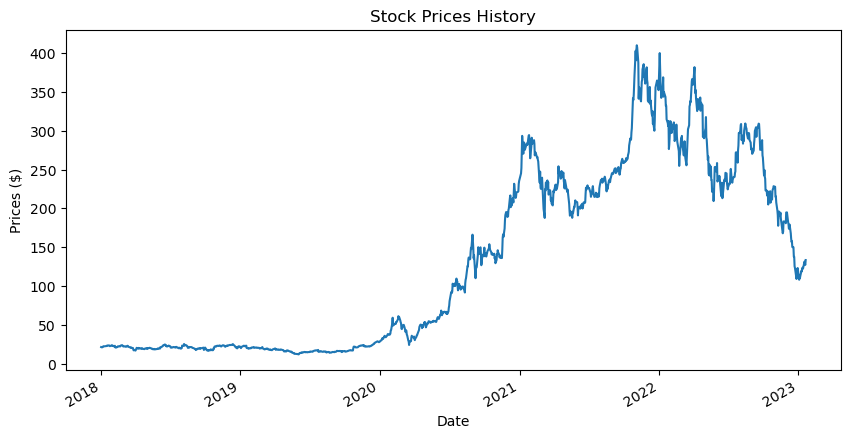

In [142]:
plt.figure(figsize=(10, 5))
plt.title('Stock Prices History')
data_TSLA_10_years.loc['2018-01-01':, 'close'].plot()
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [66]:
pprint.pprint(models_dict)

{'AAPL': {},
 'GOOG': {},
 'META': {},
 'MU': {},
 'NFLX': {},
 'NVDA': {},
 'TSLA': {2012: {'mape': 0.08259864129125806,
                 'model': <keras.engine.sequential.Sequential object at 0x7fbe7090af10>,
                 'r2': 0.8270298877619727,
                 'rmse': 15.261887581171454,
                 'time': 329.73161816596985},
          2013: {'mape': 0.03762588340481198,
                 'model': <keras.engine.sequential.Sequential object at 0x7fbe989fb430>,
                 'r2': 0.9596944556478681,
                 'rmse': 7.367244989759609,
                 'time': 292.00766587257385},
          2014: {'mape': 0.03588988945056391,
                 'model': <keras.engine.sequential.Sequential object at 0x7fbeaa83d880>,
                 'r2': 0.9607969081426248,
                 'rmse': 7.265790589187646,
                 'time': 265.70871210098267},
          2015: {'mape': 0.08243278086449175,
                 'model': <keras.engine.sequential.Sequential object at 0

In [67]:
fitting_per_year(data_AAPL_10_years, 'AAPL')

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 100)               40800     
                                                                 
 dense_25 (Dense)            (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
2/2 [==============================] - 0s 11ms/step
ГОД: 2012
R2 Score: 0.7691848408729902
RMSE: 3.9651516111606653
MAPE: 0.022171507404560236
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 100)               40800     
                                                                 
 dense_26 (Dens

Text(0, 0.5, 'Prices ($)')

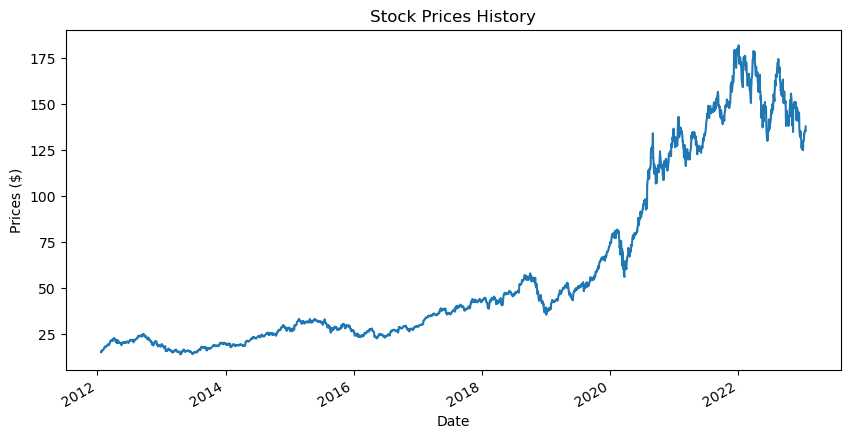

In [68]:
plt.figure(figsize=(10, 5))
plt.title('Stock Prices History')
data_AAPL_10_years['close'].plot()
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [69]:
fitting_per_year(data_GOOG_10_years, 'GOOG')

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 100)               40800     
                                                                 
 dense_36 (Dense)            (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
2/2 [==============================] - 0s 12ms/step
ГОД: 2012
R2 Score: 0.587830940458093
RMSE: 2.957209957118898
MAPE: 0.02454669838947954
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_37 (LSTM)              (None, 100)               40800     
                                                                 
 dense_37 (Dense) 

Text(0, 0.5, 'Prices ($)')

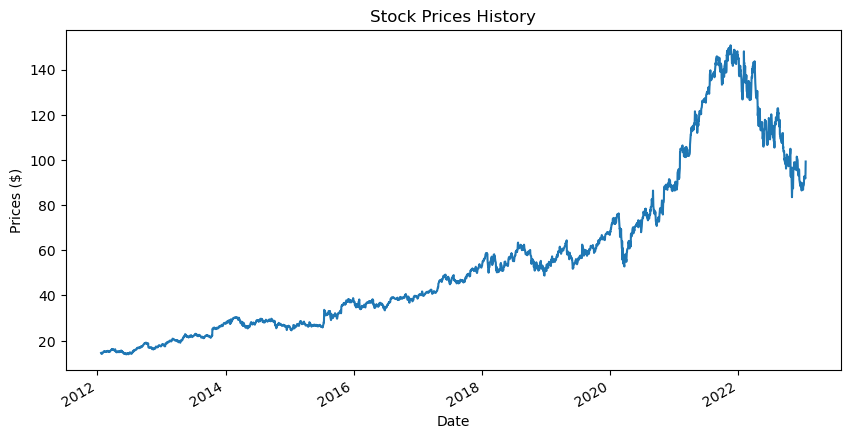

In [70]:
plt.figure(figsize=(10, 5))
plt.title('Stock Prices History')
data_GOOG_10_years['close'].plot()
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [71]:
fitting_per_year(data_META_10_years, 'META')

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_47 (LSTM)              (None, 100)               40800     
                                                                 
 dense_47 (Dense)            (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
2/2 [==============================] - 0s 10ms/step
ГОД: 2012
R2 Score: 0.7087633787567617
RMSE: 6.776526261636187
MAPE: 0.045153727214198226
Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 100)               40800     
                                                                 
 dense_48 (Dense

Text(0, 0.5, 'Prices ($)')

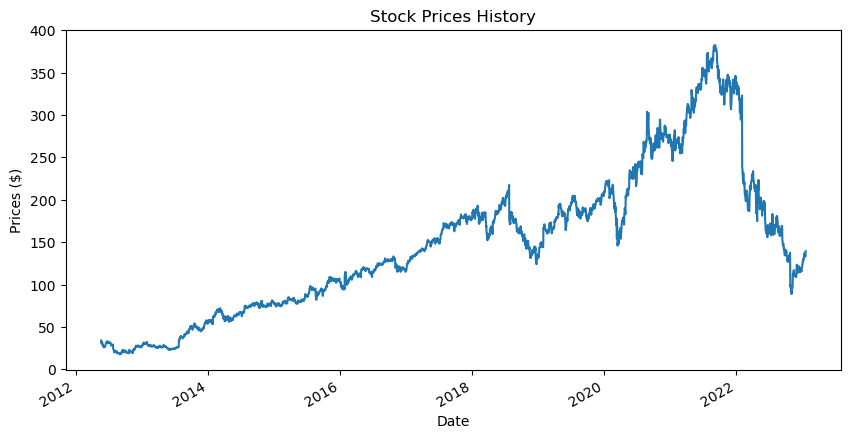

In [72]:
plt.figure(figsize=(10, 5))
plt.title('Stock Prices History')
data_META_10_years['close'].plot()
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [73]:
fitting_per_year(data_NFLX_10_years, 'NFLX')

Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_58 (LSTM)              (None, 100)               40800     
                                                                 
 dense_58 (Dense)            (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
2/2 [==============================] - 0s 10ms/step
ГОД: 2012
R2 Score: 0.7382450146101839
RMSE: 9.905130571745094
MAPE: 0.02432836319739275
Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_59 (LSTM)              (None, 100)               40800     
                                                                 
 dense_59 (Dense)

Text(0, 0.5, 'Prices ($)')

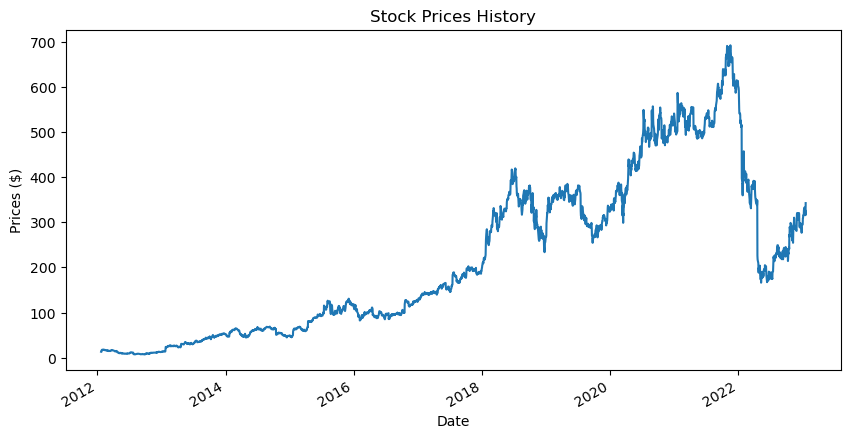

In [74]:
plt.figure(figsize=(10, 5))
plt.title('Stock Prices History')
data_NFLX_10_years['close'].plot()
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [75]:
fitting_per_year(data_NVDA_10_years, 'NVDA')

Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_69 (LSTM)              (None, 100)               40800     
                                                                 
 dense_69 (Dense)            (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
2/2 [==============================] - 0s 11ms/step
ГОД: 2012
R2 Score: 0.7973526049948252
RMSE: 6.125213157430446
MAPE: 0.03023527227533122
Model: "sequential_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_70 (LSTM)              (None, 100)               40800     
                                                                 
 dense_70 (Dense)

Text(0, 0.5, 'Prices ($)')

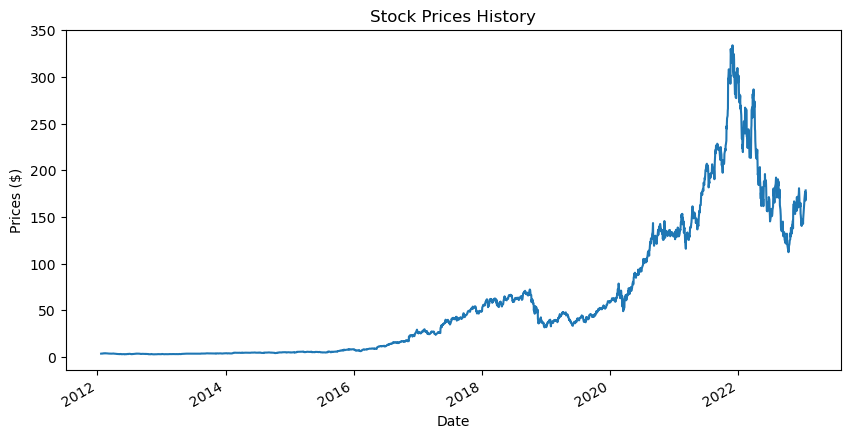

In [76]:
plt.figure(figsize=(10, 5))
plt.title('Stock Prices History')
data_NVDA_10_years['close'].plot()
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [77]:
fitting_per_year(data_MU_10_years, 'MU')

Model: "sequential_80"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_80 (LSTM)              (None, 100)               40800     
                                                                 
 dense_80 (Dense)            (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
2/2 [==============================] - 0s 12ms/step
ГОД: 2012
R2 Score: 0.7011929426904705
RMSE: 1.733656905097458
MAPE: 0.023331086201167375
Model: "sequential_81"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_81 (LSTM)              (None, 100)               40800     
                                                                 
 dense_81 (Dense

Text(0, 0.5, 'Prices ($)')

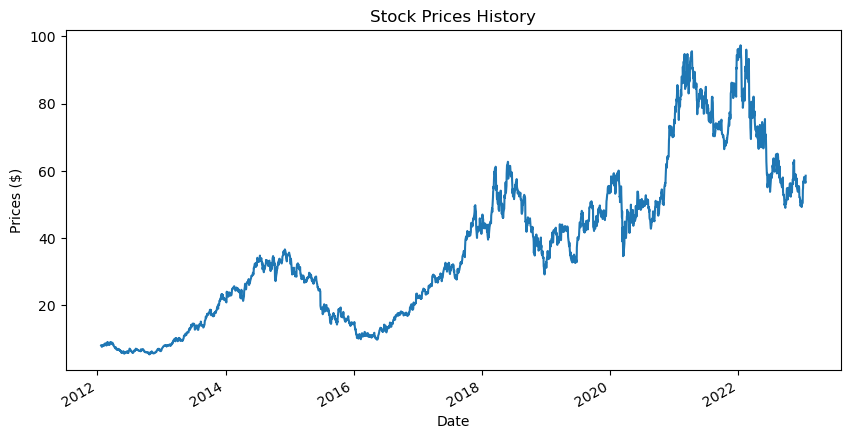

In [78]:
plt.figure(figsize=(10, 5))
plt.title('Stock Prices History')
data_MU_10_years['close'].plot()
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [ ]:
with open('../dicts/models_dict.pickle', 'wb') as handle:
    pickle.dump(models_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('../dicts/models_dict.pickle', 'rb') as handle:
#     b = pickle.load(handle)

In [80]:
pprint.pprint(models_dict)

{'AAPL': {2012: {'mape': 0.022171507404560236,
                 'model': <keras.engine.sequential.Sequential object at 0x7fbebc3dbf40>,
                 'r2': 0.7691848408729902,
                 'rmse': 3.9651516111606653,
                 'time': 329.68939113616943},
          2013: {'mape': 0.02245052350735523,
                 'model': <keras.engine.sequential.Sequential object at 0x7fbeaaf62df0>,
                 'r2': 0.768223619685958,
                 'rmse': 3.9733993967439485,
                 'time': 300.8090763092041},
          2014: {'mape': 0.017518108386011207,
                 'model': <keras.engine.sequential.Sequential object at 0x7fbeab1d6130>,
                 'r2': 0.8298878905190155,
                 'rmse': 3.404044653940846,
                 'time': 269.25472497940063},
          2015: {'mape': 0.019496795022865294,
                 'model': <keras.engine.sequential.Sequential object at 0x7fbeab6cad60>,
                 'r2': 0.7852386373302734,
               

In [4]:
def creating_data_metrics(company, key):
    r2_list = []
    rmse_list = []
    mape_list = []
    for year in np.unique(company.index.year)[0:len(np.unique(company.index.year)) - 1]:
        r2_list.append(models_dict[key][year]['r2'])
        rmse_list.append(models_dict[key][year]['rmse'])
        mape_list.append(models_dict[key][year]['mape'])
    total_list = np.column_stack((r2_list, rmse_list, mape_list))
    return pd.DataFrame(total_list, columns=['r2', 'rmse', 'mape'], index=np.unique(company.index.year)[0:len(np.unique(company.index.year)) - 1])

In [5]:
def creating_plot(data, key, metric, y_limits):
    data_plot = creating_data_metrics(data, key)

    data_plot[metric].plot(style='go-', figsize=(6, 4), label=metric.upper())
    plt.title(metric.upper()+' SCORE')
    plt.ylim(y_limits)
    plt.legend()
    tmp = 'best_year_' + metric
    plt.axvline(models_dict[key]['best_years'][tmp])
    plt.show()

In [6]:
creating_plot(data_AAPL_10_years, 'AAPL', 'r2', (-1,1))
creating_plot(data_AAPL_10_years, 'AAPL', 'rmse', (-5,10))
creating_plot(data_AAPL_10_years, 'AAPL', 'mape', (0,0.05))


plt.figure(figsize=(10, 5))
plt.title('Stock Prices History')
data_AAPL_10_years['close'].plot()
plt.xlabel('Date')
plt.ylabel('Prices ($)')
plt.axvline('2020-01-01', color='red')
plt.axhline(data_AAPL_10_years.tail(60)['close'].min(), color='orange')
plt.axhline(data_AAPL_10_years.tail(60)['close'].max(), color='orange')
plt.show()

NameError: name 'data_AAPL_10_years' is not defined

In [147]:
pprint.pprint(models_dict)

{'AAPL': {2012: {'mape': 0.022171507404560236,
                 'model': <keras.engine.sequential.Sequential object at 0x7fbebc3dbf40>,
                 'r2': 0.7691848408729902,
                 'rmse': 3.9651516111606653,
                 'time': 329.68939113616943},
          2013: {'mape': 0.02245052350735523,
                 'model': <keras.engine.sequential.Sequential object at 0x7fbeaaf62df0>,
                 'r2': 0.768223619685958,
                 'rmse': 3.9733993967439485,
                 'time': 300.8090763092041},
          2014: {'mape': 0.017518108386011207,
                 'model': <keras.engine.sequential.Sequential object at 0x7fbeab1d6130>,
                 'r2': 0.8298878905190155,
                 'rmse': 3.404044653940846,
                 'time': 269.25472497940063},
          2015: {'mape': 0.019496795022865294,
                 'model': <keras.engine.sequential.Sequential object at 0x7fbeab6cad60>,
                 'r2': 0.7852386373302734,
               

247.38983194351195

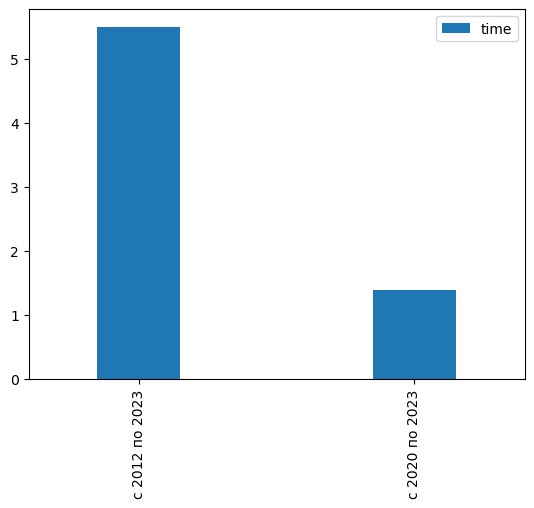

In [188]:
data_time = pd.DataFrame({'time': [models_dict['AAPL'][2012]['time'] / 60, models_dict['TSLA'][2020]['time'] / 60]}, index=['c 2012 по 2023', 'c 2020 по 2023'])
data_time.plot(kind='bar', width=0.3)



# 2012 - x%
# 2020 - 100%



models_dict['AAPL'][2020]['time'] * 3.02

In [ ]:
k

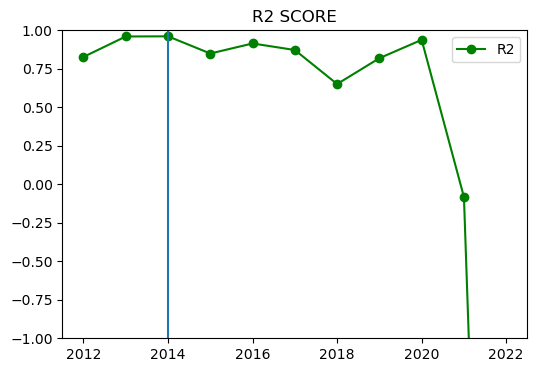

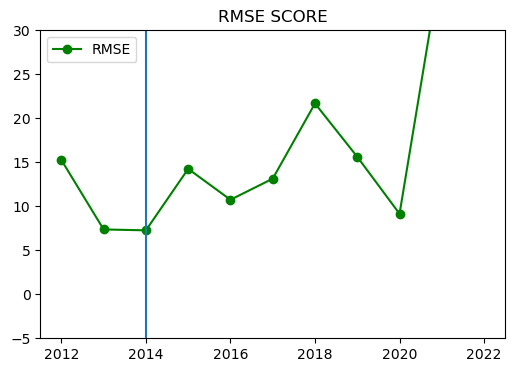

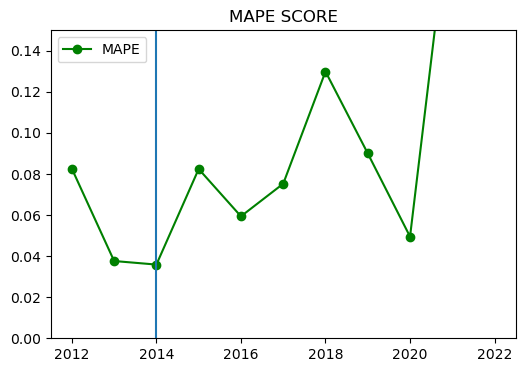

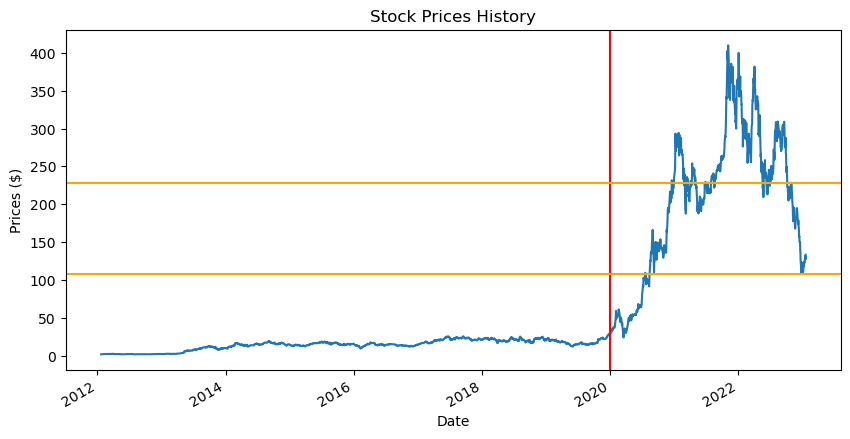

In [190]:
creating_plot(data_TSLA_10_years, 'TSLA', 'r2', (-1,1))
creating_plot(data_TSLA_10_years, 'TSLA', 'rmse', (-5,30))
creating_plot(data_TSLA_10_years, 'TSLA', 'mape', (0,0.15))

plt.figure(figsize=(10, 5))
plt.title('Stock Prices History')
data_TSLA_10_years['close'].plot()
plt.axvline('2020-01-01', color='red')
plt.xlabel('Date')
plt.ylabel('Prices ($)')
plt.axhline(data_TSLA_10_years.tail(60)['close'].min(), color='orange')
plt.axhline(data_TSLA_10_years.tail(60)['close'].max(), color='orange')
plt.show()

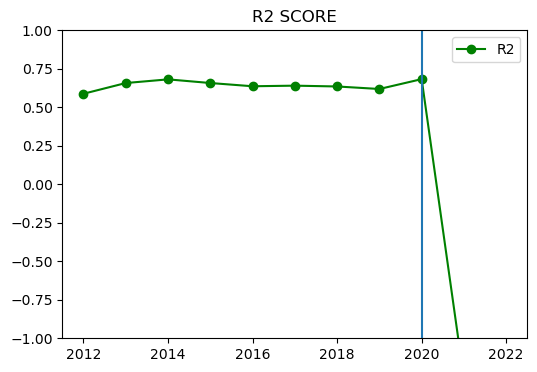

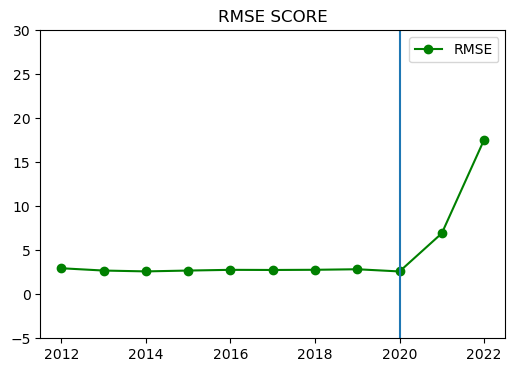

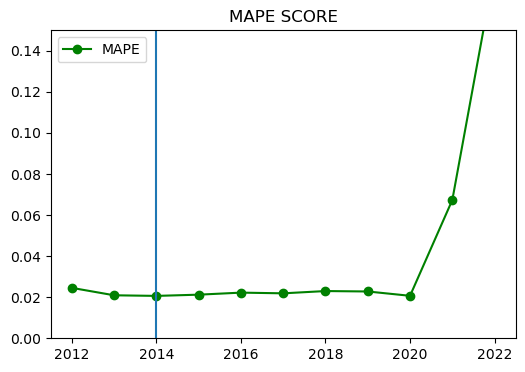

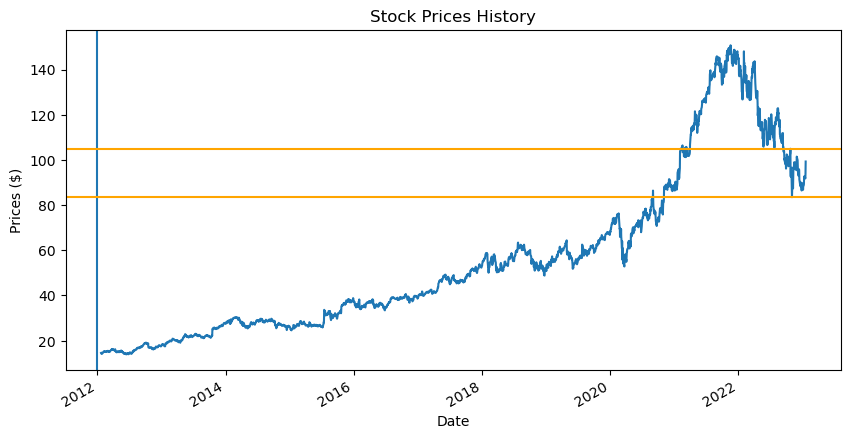

In [85]:
creating_plot(data_GOOG_10_years, 'GOOG', 'r2', (-1,1))
creating_plot(data_GOOG_10_years, 'GOOG', 'rmse', (-5,30))
creating_plot(data_GOOG_10_years, 'GOOG', 'mape', (0,0.15))

plt.figure(figsize=(10, 5))
plt.title('Stock Prices History')
data_GOOG_10_years['close'].plot()
plt.xlabel('Date')
plt.ylabel('Prices ($)')
plt.axvline('2012-01-01')
plt.axhline(data_GOOG_10_years.tail(60)['close'].min(), color='orange')
plt.axhline(data_GOOG_10_years.tail(60)['close'].max(), color='orange')
plt.show()

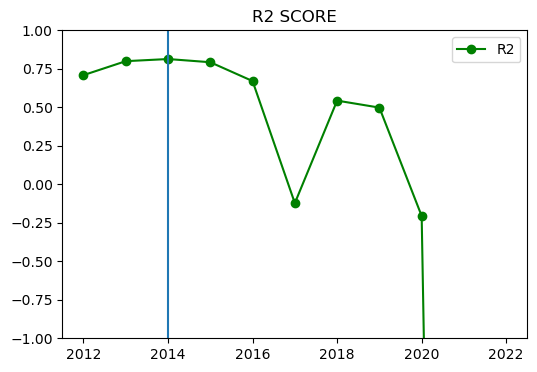

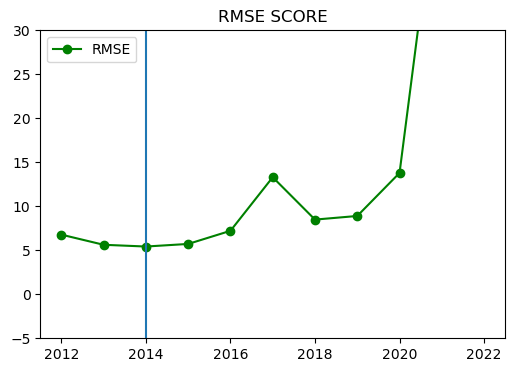

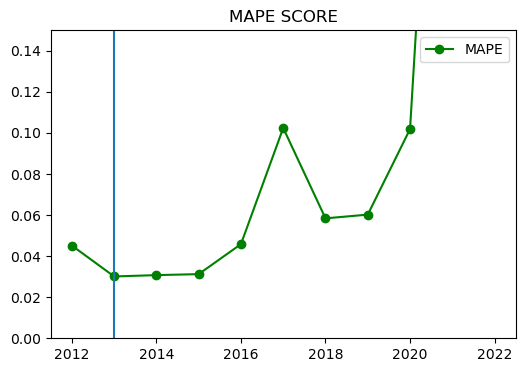

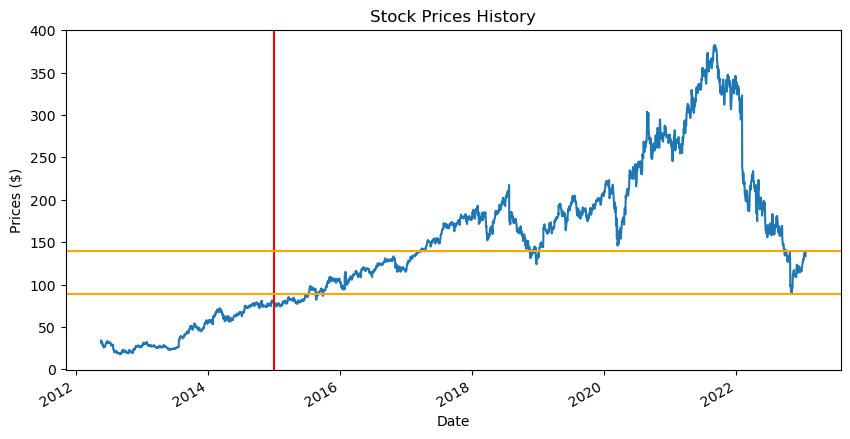

In [193]:
creating_plot(data_META_10_years, 'META', 'r2', (-1,1))
creating_plot(data_META_10_years, 'META', 'rmse', (-5,30))
creating_plot(data_META_10_years, 'META', 'mape', (0,0.15))


plt.figure(figsize=(10, 5))
plt.title('Stock Prices History')
data_META_10_years['close'].plot()
plt.xlabel('Date')
plt.ylabel('Prices ($)')
plt.axvline('2015-01-01', color='red')
plt.axhline(data_META_10_years.tail(60)['close'].min(), color='orange')
plt.axhline(data_META_10_years.tail(60)['close'].max(), color='orange')
plt.show()

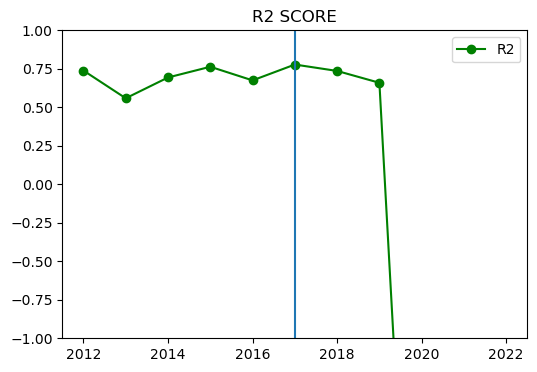

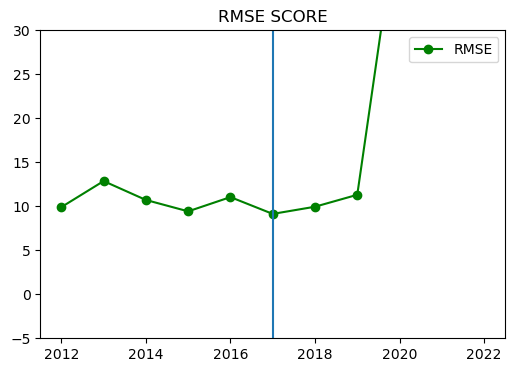

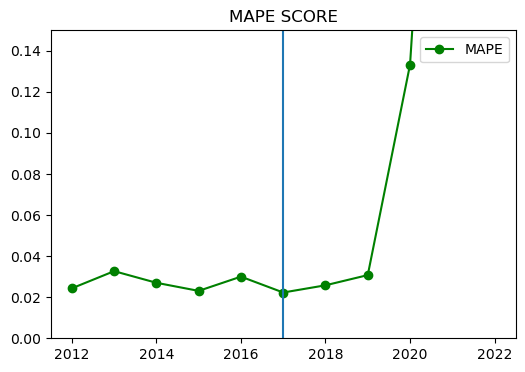

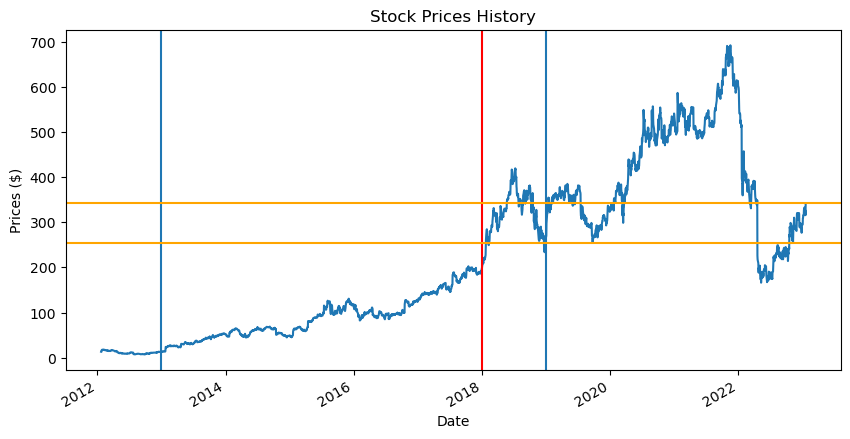

In [194]:
creating_plot(data_NFLX_10_years, 'NFLX', 'r2', (-1,1))
creating_plot(data_NFLX_10_years, 'NFLX', 'rmse', (-5,30))
creating_plot(data_NFLX_10_years, 'NFLX', 'mape', (0,0.15))


plt.figure(figsize=(10, 5))
plt.title('Stock Prices History')
data_NFLX_10_years['close'].plot()
plt.xlabel('Date')
plt.ylabel('Prices ($)')
plt.axvline('2013-01-01')
plt.axvline('2019-01-01')
plt.axvline('2018-01-01', color='red')
plt.axhline(data_NFLX_10_years.tail(60)['close'].min(), color='orange')
plt.axhline(data_NFLX_10_years.tail(60)['close'].max(), color='orange')
plt.show()

233.1499421596527

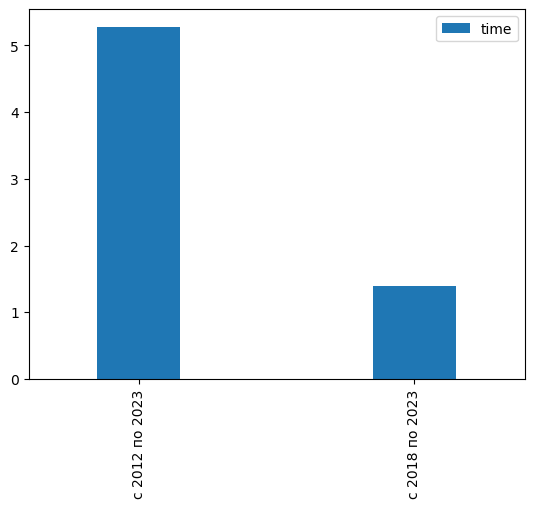

In [215]:
data_time = pd.DataFrame({'time': [models_dict['NFLX'][2012]['time'] / 60, models_dict['NFLX'][2020]['time'] / 60]}, index=['c 2012 по 2023', 'c 2018 по 2023'])
data_time.plot(kind='bar', width=0.3)



# 2012 - x% 379
# 2020 - 100%


models_dict['NFLX'][2012]['time'] - models_dict['NFLX'][2020]['time']


In [231]:
pprint.pprint(models_dict)

{'AAPL': {2012: {'mape': 0.022171507404560236,
                 'model': <keras.engine.sequential.Sequential object at 0x7fbebc3dbf40>,
                 'r2': 0.7691848408729902,
                 'rmse': 3.9651516111606653,
                 'time': 329.68939113616943},
          2013: {'mape': 0.02245052350735523,
                 'model': <keras.engine.sequential.Sequential object at 0x7fbeaaf62df0>,
                 'r2': 0.768223619685958,
                 'rmse': 3.9733993967439485,
                 'time': 300.8090763092041},
          2014: {'mape': 0.017518108386011207,
                 'model': <keras.engine.sequential.Sequential object at 0x7fbeab1d6130>,
                 'r2': 0.8298878905190155,
                 'rmse': 3.404044653940846,
                 'time': 269.25472497940063},
          2015: {'mape': 0.019496795022865294,
                 'model': <keras.engine.sequential.Sequential object at 0x7fbeab6cad60>,
                 'r2': 0.7852386373302734,
               

Text(0.5, 1.0, 'TSLA Time')

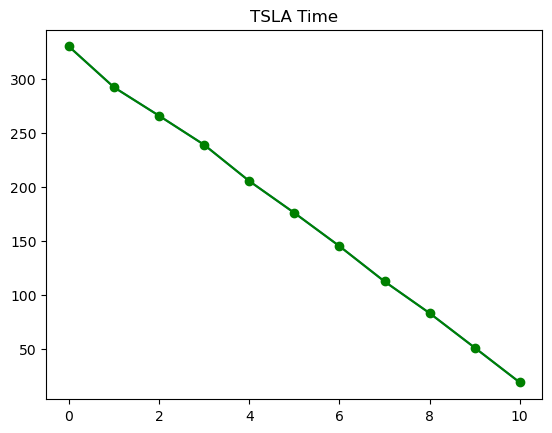

In [230]:
tmp = []
for year in models_dict['TSLA']:
    if str(year).isdigit():
        tmp.append(models_dict['TSLA'][year]['time'])
plt.plot(tmp)
pd.Series(tmp).plot(style='go-')
plt.title('TSLA Time')

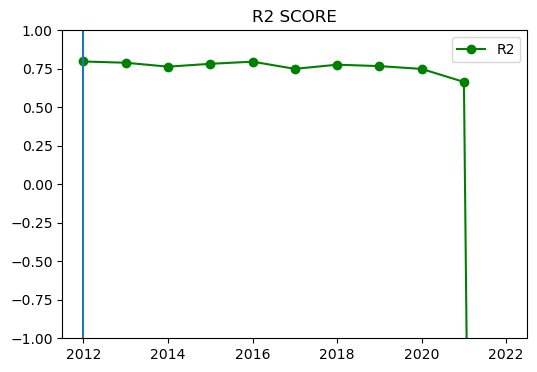

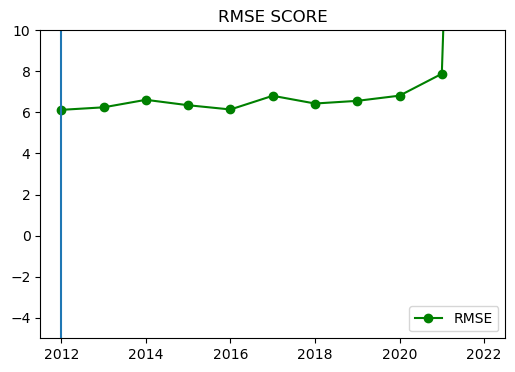

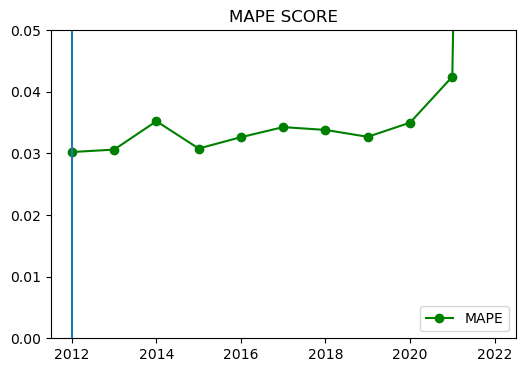

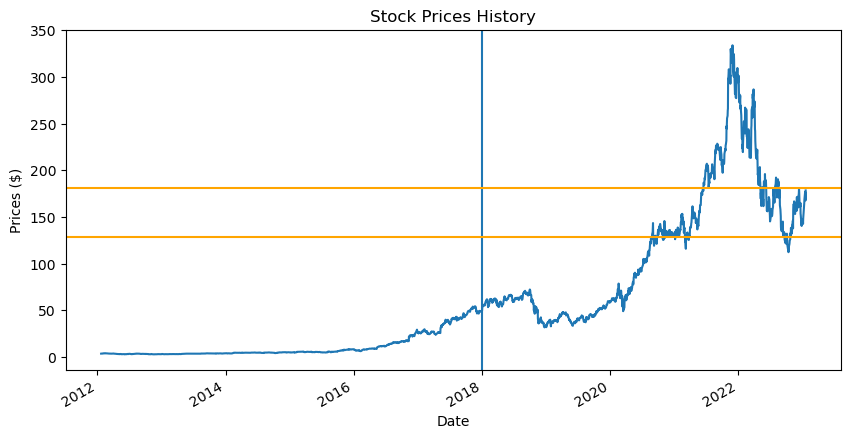

In [88]:
creating_plot(data_NVDA_10_years, 'NVDA', 'r2', (-1,1))
creating_plot(data_NVDA_10_years, 'NVDA', 'rmse', (-5,10))
creating_plot(data_NVDA_10_years, 'NVDA', 'mape', (0,0.05))


plt.figure(figsize=(10, 5))
plt.title('Stock Prices History')
data_NVDA_10_years['close'].plot()
plt.xlabel('Date')
plt.ylabel('Prices ($)')
plt.axvline('2018-01-01')
plt.axhline(data_NVDA_10_years.tail(60)['close'].min(), color='orange')
plt.axhline(data_NVDA_10_years.tail(60)['close'].max(), color='orange')
plt.show()

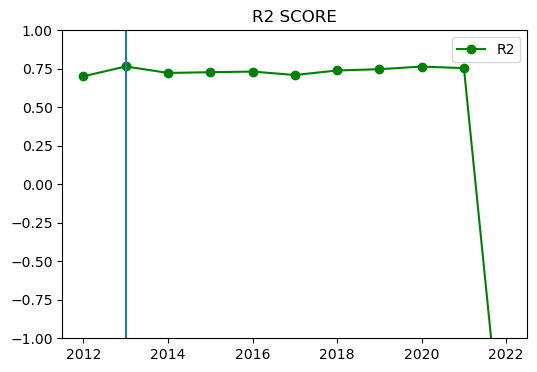

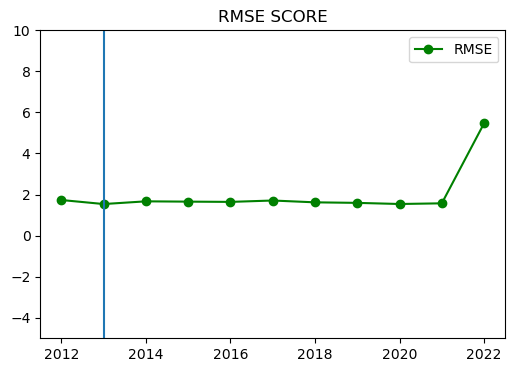

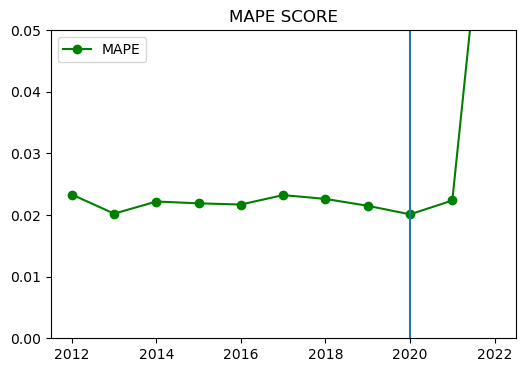

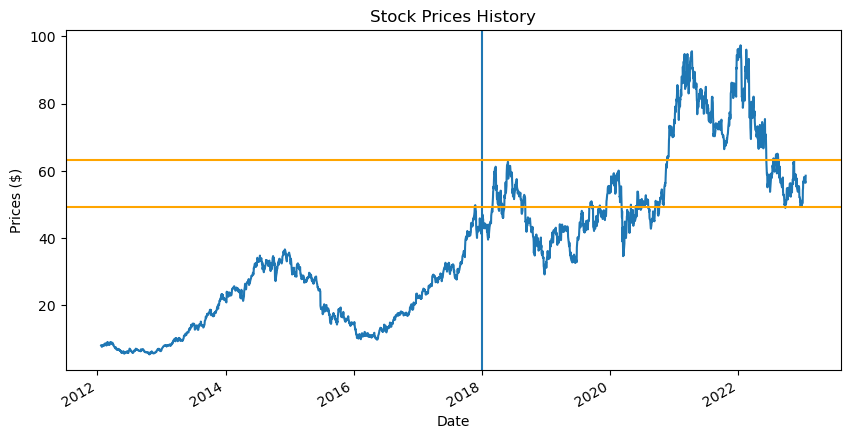

In [89]:
creating_plot(data_MU_10_years, 'MU', 'r2', (-1,1))
creating_plot(data_MU_10_years, 'MU', 'rmse', (-5,10))
creating_plot(data_MU_10_years, 'MU', 'mape', (0,0.05))


plt.figure(figsize=(10, 5))
plt.title('Stock Prices History')
data_MU_10_years['close'].plot()
plt.xlabel('Date')
plt.ylabel('Prices ($)')
plt.axvline('2018-01-01')
plt.axhline(data_MU_10_years.tail(60)['close'].min(), color='orange')
plt.axhline(data_MU_10_years.tail(60)['close'].max(), color='orange')
plt.show()

In [7]:
def fitting_per_year_700(company, key, iterator):
    total_start = time.time()
    best_r2 = 0
    best_rmse = 1000000
    best_mape = 1000

    best_year_r2 = 0
    best_year_rmse = 0
    best_year_mape = 0
    for year in np.unique(company.index.year)[0:len(np.unique(company.index.year)) - 1]:
        start = time.time()
        iter_data = company[f'{year}-01-01':]
        iter_data = iter_data['close']
        n_steps = 60
        X, y = split_sequence_new(iter_data, n_steps)

        train_size = len(X) - 60
        test_size = 60

        # scaler = MinMaxScaler(feature_range=(0, 1))
        # scaler.fit(features_train)

        features_train = X[:train_size]
        target_train = y[:train_size]
        features_test = X[len(X) - 60:]
        target_test = y[len(X) - 60:]

        # features_train = scaler.transform(features_train)
        # features_test = scaler.transform(features_test)

        model_per_day = fit_actions(features_train, target_train)
        predictions_per_day = model_per_day.predict(features_test)
        print('ГОД:', year)
        r2, rmse, mape = metrics(y_true=target_test, y_pred=predictions_per_day)

        if r2 > best_r2:
            best_r2 = r2
            best_year_r2 = year
        if best_rmse > rmse:
            best_rmse = rmse
            best_year_rmse = year
        if best_mape > mape:
            best_mape = mape
            best_year_mape = year
        end = time.time() - start
        models_dict_700[key]['iteration_' + str(iterator)][str(year)] = {'r2': r2, 'rmse': rmse, 'mape': mape, 'time': end}
        models_dict_700_lstm[key]['iteration_' + str(iterator)][str(year)] = {'model':model_per_day}
    total_end = time.time() - total_start
    models_dict_700[key]['iteration_' + str(iterator)]['total_time'] = total_end
    models_dict_700[key]['iteration_' + str(iterator)]['best_result'] = {'best_r2': best_r2, 'best_rmse': best_rmse, 'best_mape': best_mape}
    models_dict_700[key]['iteration_' + str(iterator)]['best_years'] = {'best_year_r2': best_year_r2, 'best_year_rmse': best_year_rmse,
                                      'best_year_mape': best_year_mape}



In [8]:
data_AAPL_10_years = pd.read_csv('../datasets_10_years/AAPL-10.csv', index_col=[0], parse_dates=[0])
data_AAPL_10_years.columns = data_AAPL_10_years.columns.str.lower()

In [9]:
data_GOOG_10_years = pd.read_csv('../datasets_10_years/GOOG-10.csv', index_col=[0], parse_dates=[0])
data_GOOG_10_years.columns = data_GOOG_10_years.columns.str.lower()

In [10]:
data_META_10_years = pd.read_csv('../datasets_10_years/META-10.csv', index_col=[0], parse_dates=[0])
data_META_10_years.columns = data_META_10_years.columns.str.lower()

In [11]:
data_NFLX_10_years = pd.read_csv('../datasets_10_years/NFLX-10.csv', index_col=[0], parse_dates=[0])
data_NFLX_10_years.columns = data_NFLX_10_years.columns.str.lower()

In [12]:
data_TSLA_10_years = pd.read_csv('../datasets_10_years/TSLA-10.csv', index_col=[0], parse_dates=[0])
data_TSLA_10_years.columns = data_TSLA_10_years.columns.str.lower()

In [13]:
data_NVDA_10_years = pd.read_csv('../datasets_10_years/NVDA-10.csv', index_col=[0], parse_dates=[0])
data_NVDA_10_years.columns = data_NVDA_10_years.columns.str.lower()

In [14]:
data_MU_10_years = pd.read_csv('../datasets_10_years/MU-10.csv', index_col=[0], parse_dates=[0])
data_MU_10_years.columns = data_MU_10_years.columns.str.lower()

In [15]:
models_dict_700 = {}
company_list = ['AAPL', 'GOOG', 'META', 'MU', 'NFLX', 'NVDA', 'TSLA']
for company in company_list:
    models_dict_700[company] = {}
for company in company_list:
    for i in range(1, 11):
        models_dict_700[company]['iteration_' + str(i)] = {}

In [11]:
models_dict_700_lstm = {}
for company in company_list:
    models_dict_700_lstm[company] = {}
for company in company_list:
    for i in range(1, 11):
        models_dict_700_lstm[company]['iteration_' + str(i)] = {}

In [149]:
for i in range(1, 3):
    fitting_per_year_700(data_AAPL_10_years.loc['2022-01-01':, :], 'AAPL', i)
    # fitting_per_year_700(data_GOOG_10_years, 'GOOG', i)
    # fitting_per_year_700(data_META_10_years, 'META', i)
    # fitting_per_year_700(data_MU_10_years, 'MU', i)
    # fitting_per_year_700(data_NFLX_10_years, 'NFLX', i)
    # fitting_per_year_700(data_NVDA_10_years, 'NVDA', i)
    # fitting_per_year_700(data_TSLA_10_years, 'TSLA', i)

    with open(f'../dicts/models_dict_700_iteration_{i}.pickle', 'wb') as handle:
        pickle.dump(models_dict_700, handle, protocol=pickle.HIGHEST_PROTOCOL)


with open(f'../dicts/models_dict_700.pickle', 'wb') as handle:
    pickle.dump(models_dict_700, handle, protocol=pickle.HIGHEST_PROTOCOL)
    # with open('../dicts/models_dict.pickle', 'rb') as handle:
    #     b = pickle.load(handle)

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 100)               40800     
                                                                 
 dense_40 (Dense)            (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
2/2 [==============================] - 0s 11ms/step
ГОД: 2022
R2 Score: -58.28989637880096
RMSE: 63.55035473402931
MAPE: 0.446735507233204
Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_41 (LSTM)              (None, 100)               40800     
                                                                 
 dense_41 (Dense)  

In [150]:
pprint.pprint(models_dict_700)

{'AAPL': {'iteration_1': {'2022': {'mape': 0.446735507233204,
                                   'r2': -58.28989637880096,
                                   'rmse': 63.55035473402931,
                                   'time': 21.433423042297363},
                          'best_result': {'best_mape': 0.446735507233204,
                                          'best_r2': 0,
                                          'best_rmse': 63.55035473402931},
                          'best_years': {'best_year_mape': 2022,
                                         'best_year_r2': 0,
                                         'best_year_rmse': 2022},
                          'total_time': 21.43390417098999},
          'iteration_10': {},
          'iteration_2': {'2022': {'mape': 0.42861704513600196,
                                   'r2': -53.692891692049535,
                                   'rmse': 61.03698547376921,
                                   'time': 18.620839834213257},
             

In [151]:
pprint.pprint(models_dict_700_lstm)

{'AAPL': {'iteration_1': {'2022': {'model': <keras.engine.sequential.Sequential object at 0x7fc38d4337f0>}},
          'iteration_10': {},
          'iteration_2': {'2022': {'model': <keras.engine.sequential.Sequential object at 0x7fc3689150a0>}},
          'iteration_3': {},
          'iteration_4': {},
          'iteration_5': {},
          'iteration_6': {},
          'iteration_7': {},
          'iteration_8': {},
          'iteration_9': {}},
 'GOOG': {'iteration_1': {},
          'iteration_10': {},
          'iteration_2': {},
          'iteration_3': {},
          'iteration_4': {},
          'iteration_5': {},
          'iteration_6': {},
          'iteration_7': {},
          'iteration_8': {},
          'iteration_9': {}},
 'META': {'iteration_1': {},
          'iteration_10': {},
          'iteration_2': {},
          'iteration_3': {},
          'iteration_4': {},
          'iteration_5': {},
          'iteration_6': {},
          'iteration_7': {},
          'iteration_8'

In [10]:
with open('../dicts/models_dict_700.pickle', 'rb') as handle:
    b = pickle.load(handle)

In [11]:
pprint.pprint(b)

{'AAPL': {'iteration_1': {'2022': {'mape': 0.446735507233204,
                                   'r2': -58.28989637880096,
                                   'rmse': 63.55035473402931,
                                   'time': 21.433423042297363},
                          'best_result': {'best_mape': 0.446735507233204,
                                          'best_r2': 0,
                                          'best_rmse': 63.55035473402931},
                          'best_years': {'best_year_mape': 2022,
                                         'best_year_r2': 0,
                                         'best_year_rmse': 2022},
                          'total_time': 21.43390417098999},
          'iteration_10': {},
          'iteration_2': {'2022': {'mape': 0.42861704513600196,
                                   'r2': -53.692891692049535,
                                   'rmse': 61.03698547376921,
                                   'time': 18.620839834213257},
             

In [12]:
pprint.pprint(b)

{'AAPL': {'iteration_1': {'2022': {'mape': 0.446735507233204,
                                   'r2': -58.28989637880096,
                                   'rmse': 63.55035473402931,
                                   'time': 21.433423042297363},
                          'best_result': {'best_mape': 0.446735507233204,
                                          'best_r2': 0,
                                          'best_rmse': 63.55035473402931},
                          'best_years': {'best_year_mape': 2022,
                                         'best_year_r2': 0,
                                         'best_year_rmse': 2022},
                          'total_time': 21.43390417098999},
          'iteration_10': {},
          'iteration_2': {'2022': {'mape': 0.42861704513600196,
                                   'r2': -53.692891692049535,
                                   'rmse': 61.03698547376921,
                                   'time': 18.620839834213257},
             

NameError: name 'data_AAPL_10_years' is not defined

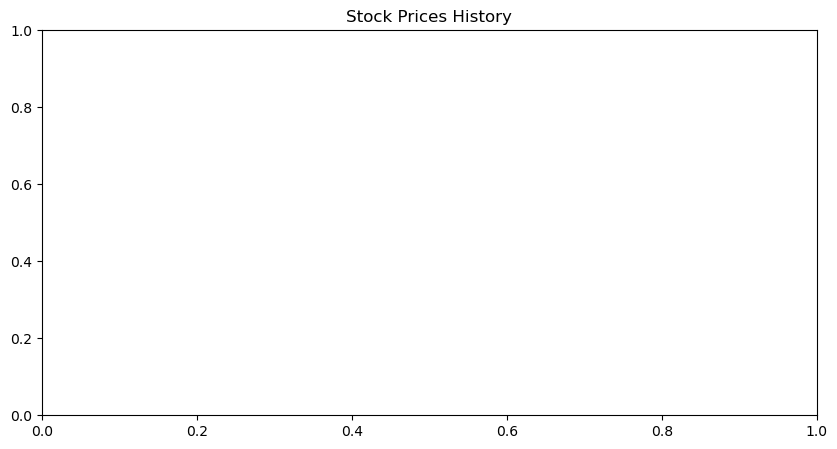

In [13]:
plt.figure(figsize=(10, 5))
plt.title('Stock Prices History')
data_AAPL_10_years['close'].plot()
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [16]:
data_AAPL_10_years = pd.read_csv('../datasets_10_years/AAPL-10.csv', index_col=[0], parse_dates=[0])
data_AAPL_10_years.columns = data_AAPL_10_years.columns.str.lower()

In [17]:
data_GOOG_10_years = pd.read_csv('../datasets_10_years/GOOG-10.csv', index_col=[0], parse_dates=[0])
data_GOOG_10_years.columns = data_GOOG_10_years.columns.str.lower()

In [18]:
data_META_10_years = pd.read_csv('../datasets_10_years/META-10.csv', index_col=[0], parse_dates=[0])
data_META_10_years.columns = data_META_10_years.columns.str.lower()

In [19]:
data_NFLX_10_years = pd.read_csv('../datasets_10_years/NFLX-10.csv', index_col=[0], parse_dates=[0])
data_NFLX_10_years.columns = data_NFLX_10_years.columns.str.lower()

In [20]:
data_TSLA_10_years = pd.read_csv('../datasets_10_years/TSLA-10.csv', index_col=[0], parse_dates=[0])
data_TSLA_10_years.columns = data_TSLA_10_years.columns.str.lower()

In [21]:
data_NVDA_10_years = pd.read_csv('../datasets_10_years/NVDA-10.csv', index_col=[0], parse_dates=[0])
data_NVDA_10_years.columns = data_NVDA_10_years.columns.str.lower()

In [22]:
data_MU_10_years = pd.read_csv('../datasets_10_years/MU-10.csv', index_col=[0], parse_dates=[0])
data_MU_10_years.columns = data_MU_10_years.columns.str.lower()

In [13]:
with open('../dicts/models_dict_700_iteration_7.pickle', 'rb') as handle:
    my_dict = pickle.load(handle)

In [14]:
pprint.pprint(my_dict)

{'AAPL': {'iteration_1': {'2012': {'mape': 0.018252058662876755,
                                   'r2': 0.8174854300459226,
                                   'rmse': 3.525952059816449,
                                   'time': 785.2199473381042},
                          '2013': {'mape': 0.021670905875743274,
                                   'r2': 0.7796965432233345,
                                   'rmse': 3.8738097624397914,
                                   'time': 535.4500000476837},
                          '2014': {'mape': 0.021409012918418967,
                                   'r2': 0.7582107048848818,
                                   'rmse': 4.058318875801813,
                                   'time': 444.77055740356445},
                          '2015': {'mape': 0.018565557148672317,
                                   'r2': 0.8165177648017405,
                                   'rmse': 3.535286741449915,
                                   'time': 395.4649345874

In [15]:
company_list = ['AAPL', 'GOOG', 'META', 'MU', 'NFLX', 'NVDA', 'TSLA']

In [16]:
new_dict = {}
for company in company_list:
    new_dict[company] = {}
for company in company_list:
    for year in range(2012, 2023):
        new_dict[company][str(year)] = {}
new_dict

{'AAPL': {'2012': {},
  '2013': {},
  '2014': {},
  '2015': {},
  '2016': {},
  '2017': {},
  '2018': {},
  '2019': {},
  '2020': {},
  '2021': {},
  '2022': {}},
 'GOOG': {'2012': {},
  '2013': {},
  '2014': {},
  '2015': {},
  '2016': {},
  '2017': {},
  '2018': {},
  '2019': {},
  '2020': {},
  '2021': {},
  '2022': {}},
 'META': {'2012': {},
  '2013': {},
  '2014': {},
  '2015': {},
  '2016': {},
  '2017': {},
  '2018': {},
  '2019': {},
  '2020': {},
  '2021': {},
  '2022': {}},
 'MU': {'2012': {},
  '2013': {},
  '2014': {},
  '2015': {},
  '2016': {},
  '2017': {},
  '2018': {},
  '2019': {},
  '2020': {},
  '2021': {},
  '2022': {}},
 'NFLX': {'2012': {},
  '2013': {},
  '2014': {},
  '2015': {},
  '2016': {},
  '2017': {},
  '2018': {},
  '2019': {},
  '2020': {},
  '2021': {},
  '2022': {}},
 'NVDA': {'2012': {},
  '2013': {},
  '2014': {},
  '2015': {},
  '2016': {},
  '2017': {},
  '2018': {},
  '2019': {},
  '2020': {},
  '2021': {},
  '2022': {}},
 'TSLA': {'2012': {},
  

In [21]:
for company in company_list:
    for year in range(2012, 2023):
        total_r2 = 0
        total_r2_std = list()
        total_rmse = 0
        total_rmse_std = list()
        total_mape = 0
        total_mape_std = list()
        total_time = 0
        for i in range(1, 8):
            total_r2 += my_dict[company][f'iteration_{i}'][str(year)]['r2']
            total_r2_std.append(my_dict[company][f'iteration_{i}'][str(year)]['r2'])
            total_rmse += my_dict[company][f'iteration_{i}'][str(year)]['rmse']
            total_rmse_std.append(my_dict[company][f'iteration_{i}'][str(year)]['rmse'])
            total_mape += my_dict[company][f'iteration_{i}'][str(year)]['mape']
            total_mape_std.append(my_dict[company][f'iteration_{i}'][str(year)]['mape'])
            total_time += my_dict[company][f'iteration_{i}'][str(year)]['time']
            # print('R2 = ', my_dict[company][f'iteration_{i}'][str(year)]['r2'])
        new_dict[company][str(year)]['total_r2'] = total_r2 / 7
        new_dict[company][str(year)]['total_r2_std'] = np.std(total_r2_std)
        new_dict[company][str(year)]['total_rmse'] = total_rmse / 7
        new_dict[company][str(year)]['total_rmse_std'] = np.std(total_rmse_std)
        new_dict[company][str(year)]['total_mape'] = total_mape / 7
        new_dict[company][str(year)]['total_mape_std'] = np.std(total_mape_std)
        new_dict[company][str(year)]['total_time'] = total_time / 7
pprint.pprint(new_dict)

{'AAPL': {'2012': {'total_mape': 0.020302505092117146,
                   'total_mape_std': 0.0026822469416312583,
                   'total_r2': 0.7899874350624254,
                   'total_r2_std': 0.034286476514050014,
                   'total_rmse': 3.770313071639767,
                   'total_rmse_std': 0.30026177673120574,
                   'total_time': 737.5086648123605},
          '2013': {'total_mape': 0.019839097578824075,
                   'total_mape_std': 0.0021337909298873364,
                   'total_r2': 0.8017751875955412,
                   'total_r2_std': 0.0268450035000822,
                   'total_rmse': 3.666541136672945,
                   'total_rmse_std': 0.24279209374847804,
                   'total_time': 614.5891530854361},
          '2014': {'total_mape': 0.02154882865672521,
                   'total_mape_std': 0.0044304551467751665,
                   'total_r2': 0.7654444283623981,
                   'total_r2_std': 0.06926233698968012,
         

In [18]:
def total_metrics(company):
    mape_list = list()
    mape_std_list = list()
    r2_list = list()
    r2_std_list = list()
    rmse_list = list()
    rmse_std_list = list()
    time_list = list()

    for year in range(2012, 2023):
        mape_list.append(new_dict[company][str(year)]['total_mape'])
        mape_std_list.append(new_dict[company][str(year)]['total_mape_std'])
        r2_list.append(new_dict[company][str(year)]['total_r2'])
        r2_std_list.append(new_dict[company][str(year)]['total_r2_std'])
        rmse_list.append(new_dict[company][str(year)]['total_rmse'])
        rmse_std_list.append(new_dict[company][str(year)]['total_rmse_std'])
        time_list.append(new_dict[company][str(year)]['total_time'])
    return pd.Series(mape_list, index=range(2012, 2023)), pd.Series(r2_list, index=range(2012, 2023)), pd.Series(rmse_list, index=range(2012, 2023)), pd.Series(time_list, index=range(2012, 2023)), pd.Series(mape_std_list, index=range(2012, 2023)), pd.Series(r2_std_list, index=range(2012, 2023)), pd.Series(rmse_std_list, index=range(2012, 2023))

In [19]:
def total_plot(total_mape, total_r2, total_rmse, total_time, total_mape_std, total_r2_std, total_rmse_std, company):
    data = pd.read_csv(f'../datasets_10_years/{company}-10.csv', index_col=[0], parse_dates=[0])
    data.columns = data.columns.str.lower()
    plt.figure(figsize=(10, 5))
    plt.title(f'Stock Prices History {company}')
    data['close'].plot()
    plt.xlabel('Date')
    plt.ylabel('Prices ($)')
    plt.axhline(data.tail(60)['close'].min(), color='orange')
    plt.axhline(data.tail(60)['close'].max(), color='orange')
    plt.show()


    total_mape.plot(style='go-', figsize=(10, 4), label='MAPE')
    plt.title(f'MAPE {company}')
    plt.ylim(-1, 1)
    plt.legend()
    for year in range(2012, 2023):
        for i in range(1, 8):
            plt.scatter(year, my_dict[company][f'iteration_{i}'][str(year)]['mape'], color='orange', marker='o', alpha=0.3)
    plt.show()
    print(total_mape_std)


    total_r2.plot(style='go-', figsize=(10, 4), label='R2')
    plt.title(f'R2 {company}')
    plt.ylim(-1, 1)
    plt.legend()
    for year in range(2012, 2023):
        for i in range(1, 8):
            plt.scatter(year, my_dict[company][f'iteration_{i}'][str(year)]['r2'], color='orange', marker='o', alpha=0.3)
    plt.show()
    print(total_r2_std)
    total_rmse.plot(style='go-', figsize=(10, 4), label='RMSE')
    plt.title(f'RMSE {company}')
    plt.ylim(-5, 50)
    plt.legend()

    for year in range(2012, 2023):
        for i in range(1, 8):
            plt.scatter(year, my_dict[company][f'iteration_{i}'][str(year)]['rmse'], color='orange', marker='o', alpha=0.3)
    plt.show()
    print(total_rmse_std)
    total_time.plot(style='go-', figsize=(10, 4), label='TIME')
    plt.title(f'TIME {company}')
    plt.legend()
    plt.show()

In [20]:
def total_metrics_and_plot(company):
    total_mape, total_r2, total_rmse, total_time, total_mape_std, total_r2_std, total_rmse_std  = total_metrics(company)
    total_plot(total_mape, total_r2, total_rmse, total_time, total_mape_std, total_r2_std, total_rmse_std, company)

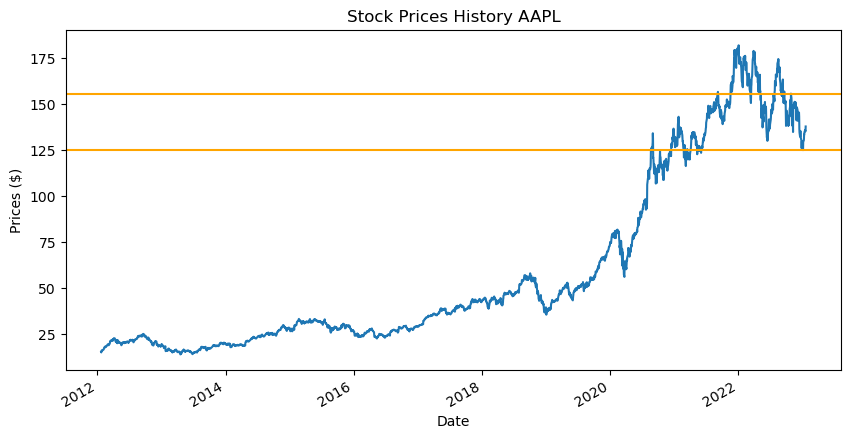

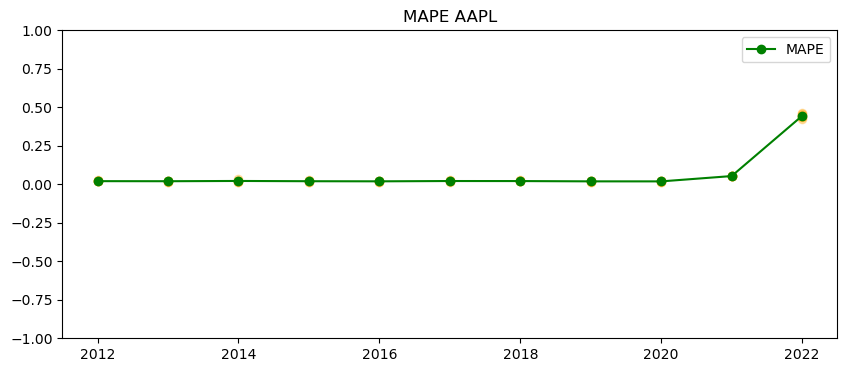

2012    0.002682
2013    0.002134
2014    0.004430
2015    0.002920
2016    0.001416
2017    0.003249
2018    0.002186
2019    0.001052
2020    0.000936
2021    0.001498
2022    0.012884
dtype: float64


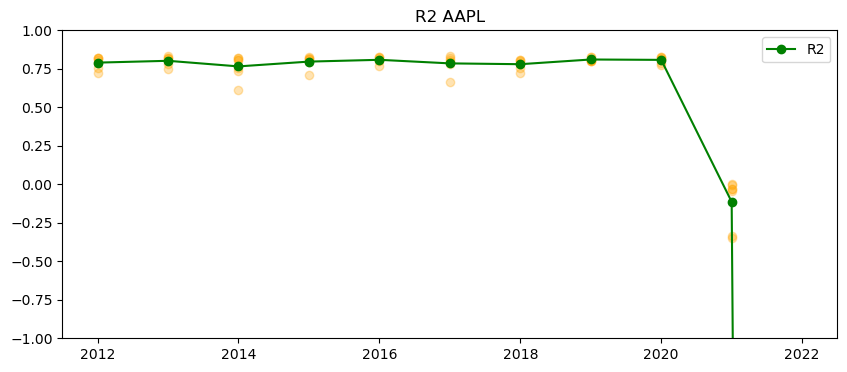

2012    0.034286
2013    0.026845
2014    0.069262
2015    0.037953
2016    0.018341
2017    0.050790
2018    0.029744
2019    0.009948
2020    0.016986
2021    0.145673
2022    3.312782
dtype: float64


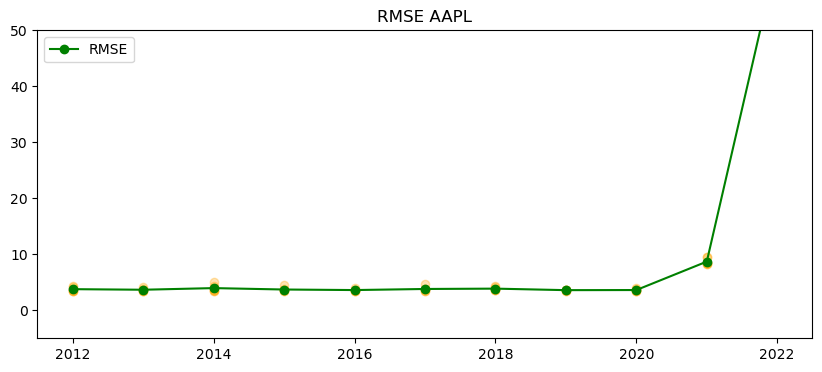

2012    0.300262
2013    0.242792
2014    0.548464
2015    0.324712
2016    0.169145
2017    0.419259
2018    0.253896
2019    0.095143
2020    0.157857
2021    0.554538
2022    1.787679
dtype: float64


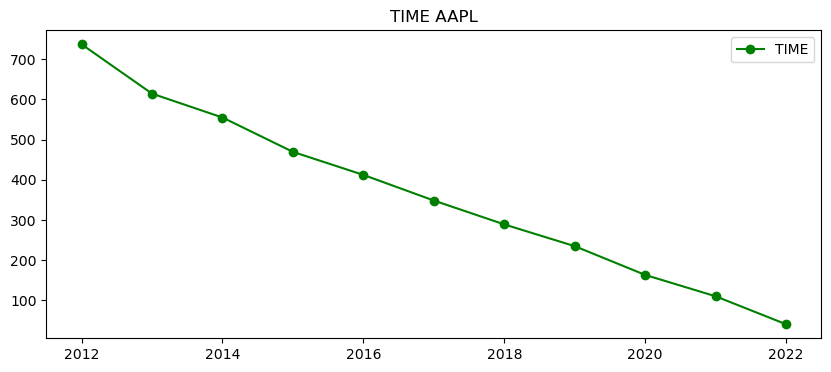

In [45]:
total_metrics_and_plot('AAPL')

#fill 2 линии сверхус низу
#высокочастотные ряды
#другая модель
#подходы

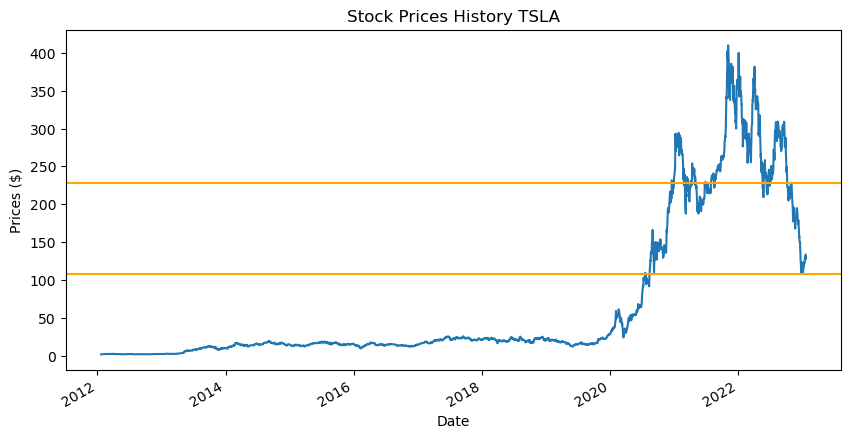

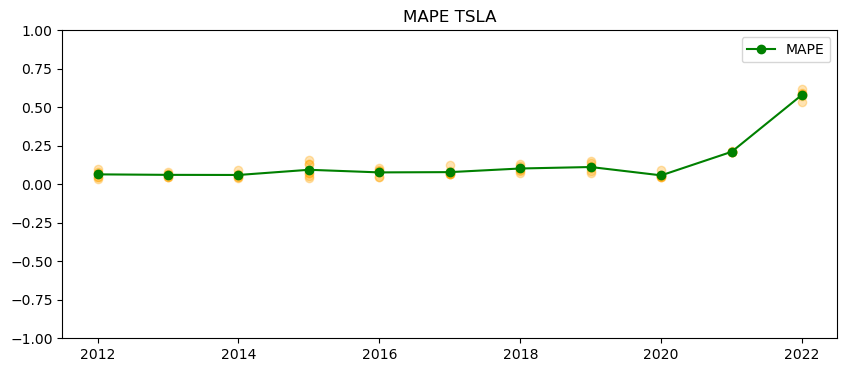

2012    0.021183
2013    0.012120
2014    0.016057
2015    0.041328
2016    0.019350
2017    0.020178
2018    0.018928
2019    0.026388
2020    0.014020
2021    0.003406
2022    0.023265
dtype: float64


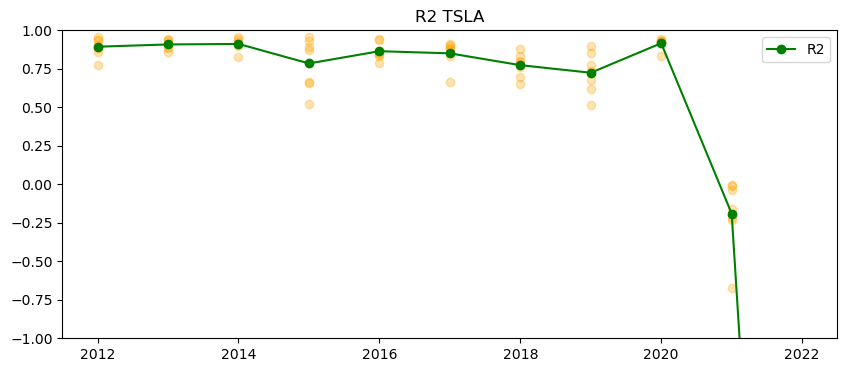

2012    0.057678
2013    0.029387
2014    0.039025
2015    0.154432
2016    0.052442
2017    0.080056
2018    0.072026
2019    0.122858
2020    0.035019
2021    0.215352
2022    0.534064
dtype: float64


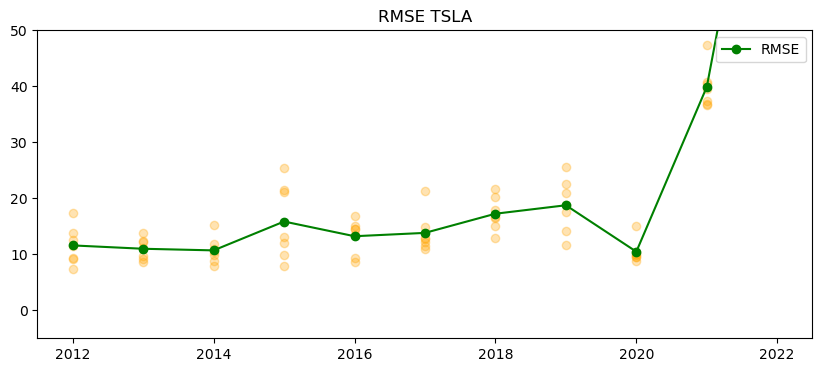

2012    3.108618
2013    1.779773
2014    2.234864
2015    6.223716
2016    2.834122
2017    3.279994
2018    2.778233
2019    4.438649
2020    1.930840
2021    3.446822
2022    3.422683
dtype: float64


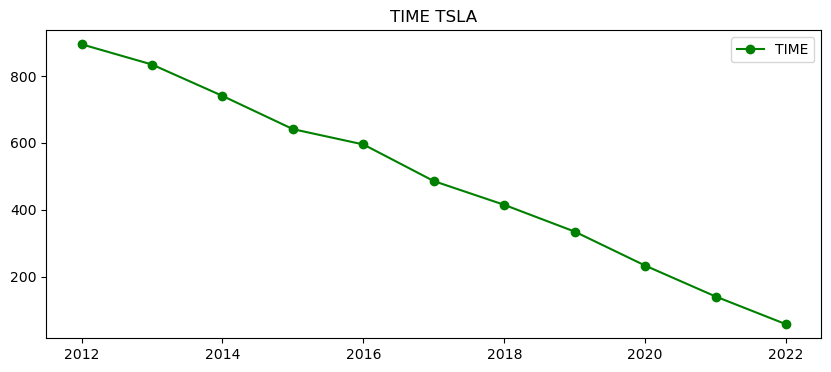

In [46]:
total_metrics_and_plot('TSLA')

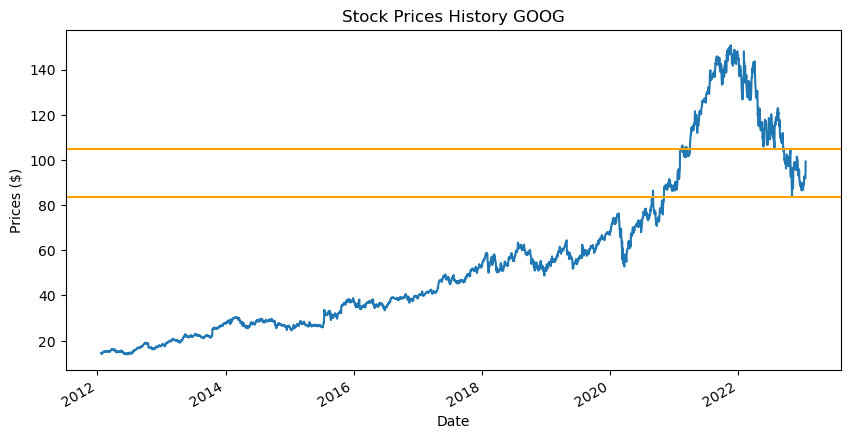

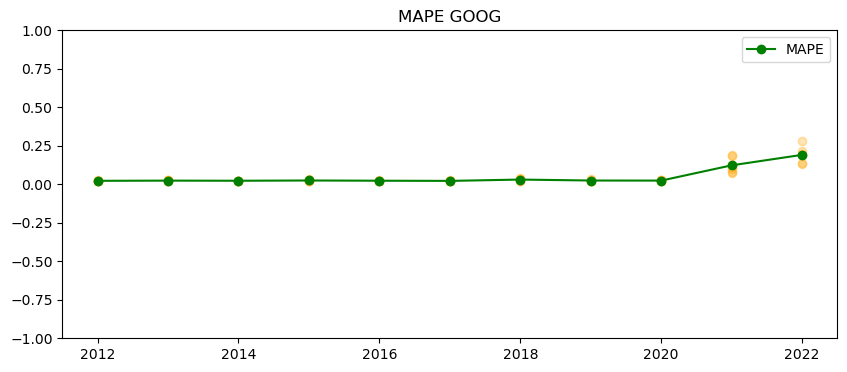

2012    0.001760
2013    0.001941
2014    0.000710
2015    0.004015
2016    0.001050
2017    0.001707
2018    0.005723
2019    0.004407
2020    0.003109
2021    0.044231
2022    0.046320
dtype: float64


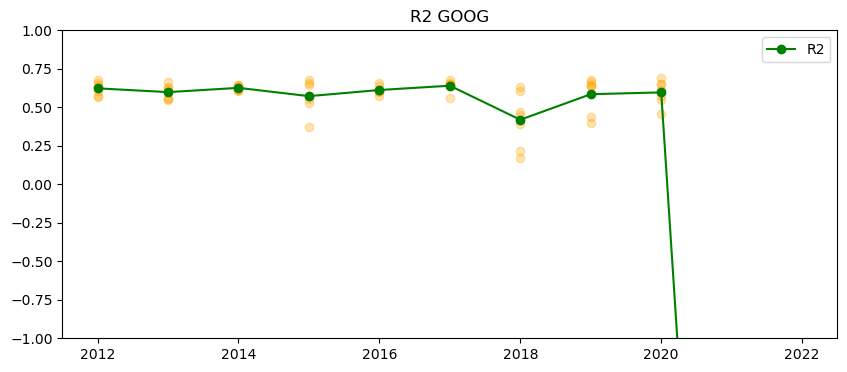

2012    0.038166
2013    0.041219
2014    0.015872
2015    0.097017
2016    0.026264
2017    0.033271
2018    0.163730
2019    0.106719
2020    0.073859
2021    4.806207
2022    7.746430
dtype: float64


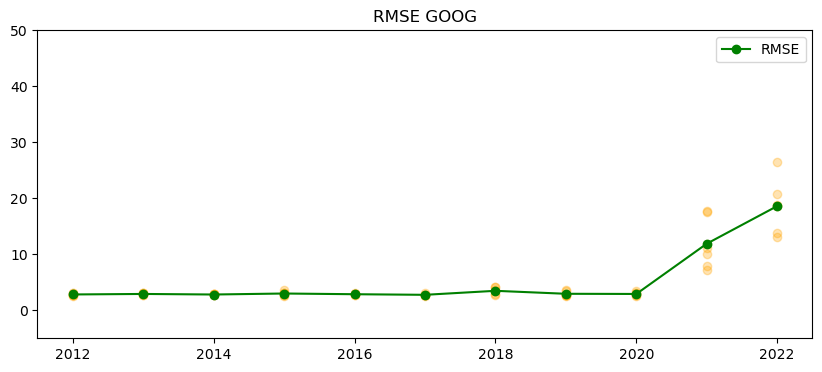

2012    0.142816
2013    0.150233
2014    0.059818
2015    0.329151
2016    0.097804
2017    0.123642
2018    0.494656
2019    0.363873
2020    0.262928
2021    3.949795
2022    4.170033
dtype: float64


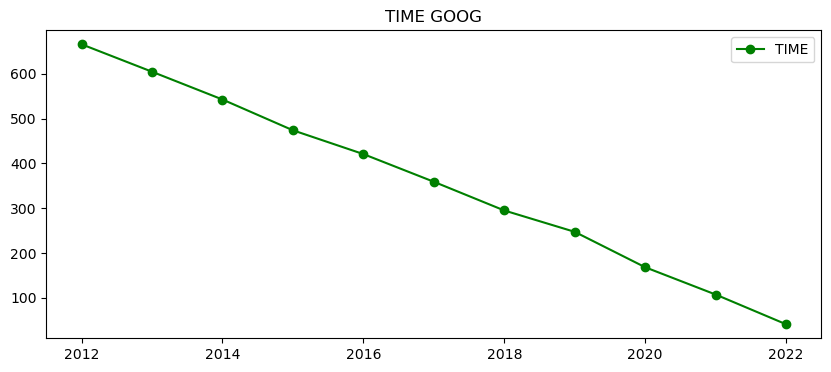

In [47]:
total_metrics_and_plot('GOOG')

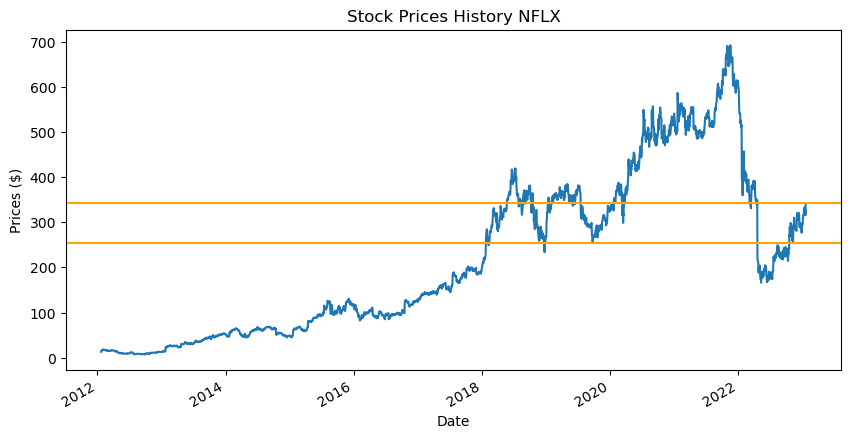

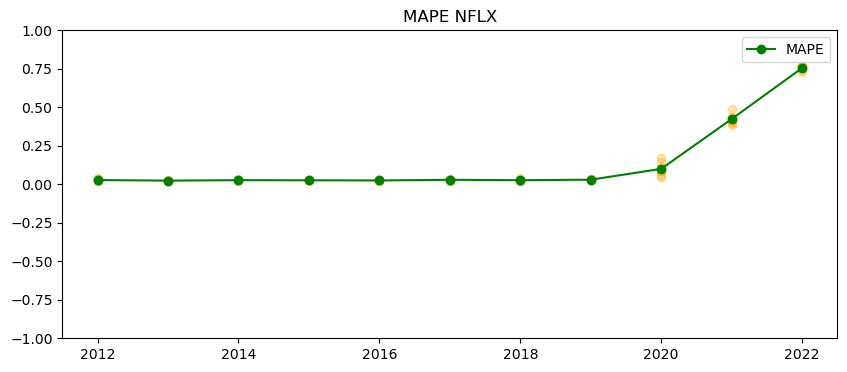

2012    0.006855
2013    0.000640
2014    0.003922
2015    0.001593
2016    0.001350
2017    0.004810
2018    0.006052
2019    0.002845
2020    0.040964
2021    0.030924
2022    0.014296
dtype: float64


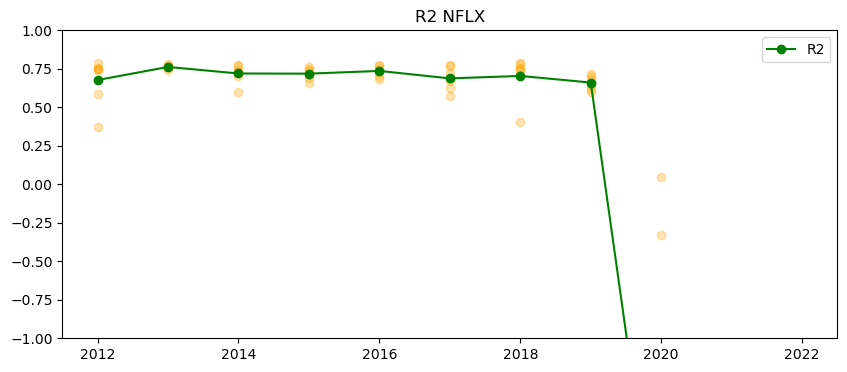

2012    0.139078
2013    0.010940
2014    0.054975
2015    0.033190
2016    0.030442
2017    0.069641
2018    0.125334
2019    0.041971
2020    2.383792
2021    6.469395
2022    5.082986
dtype: float64


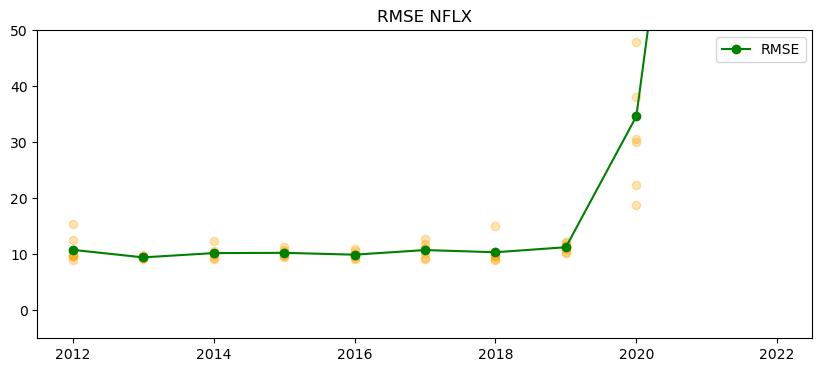

2012     2.137679
2013     0.216323
2014     0.953604
2015     0.599642
2016     0.569678
2017     1.203644
2018     1.936539
2019     0.698405
2020    12.057944
2021     9.106226
2022     4.239844
dtype: float64


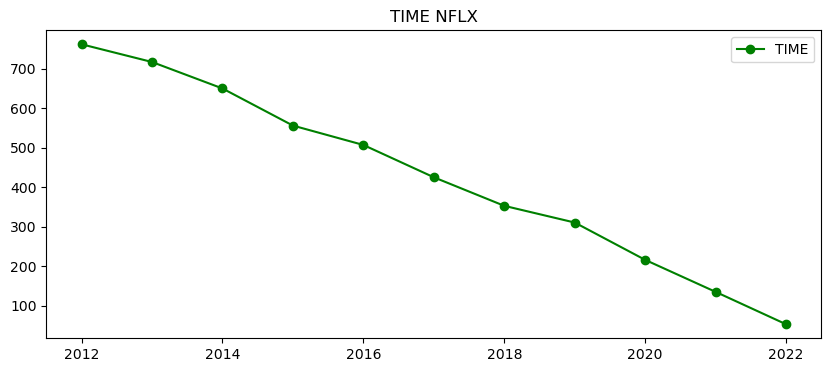

In [48]:
total_metrics_and_plot('NFLX')

In [49]:
from alpha_vantage.timeseries import TimeSeries

In [50]:
key = 'JG9EW019LMFBW136'

In [30]:
ts = TimeSeries(key, output_format='pandas')
data, meta = ts.get_intraday('TSLA', interval='5min', outputsize='full')

In [31]:
data

1. open  2. high  3. low  4. close  5. volume
date                                                              
2023-02-24 20:00:00   196.29   196.60  196.25    196.48    40922.0
2023-02-24 19:55:00   196.05   196.28  196.02    196.25    18619.0
2023-02-24 19:50:00   196.10   196.15  196.06    196.06    15429.0
2023-02-24 19:45:00   196.15   196.15  196.11    196.13     8251.0
2023-02-24 19:40:00   196.19   196.19  196.11    196.18     5385.0
...                      ...      ...     ...       ...        ...
2023-01-30 04:25:00   177.29   177.37  176.67    176.87    97138.0
2023-01-30 04:20:00   175.76   177.30  175.60    177.29   126503.0
2023-01-30 04:15:00   173.95   175.78  173.95    175.73   143863.0
2023-01-30 04:10:00   173.31   174.40  173.23    173.95   166470.0
2023-01-30 04:05:00   178.50   178.96  173.40    173.40   281262.0

[3648 rows x 5 columns]

In [141]:
import csv
import requests
from time import sleep

In [142]:
def get_data_from_API():
    data_API = pd.DataFrame()
    for year in [2, 1]:
        sleep(15)
        for month in range(12, 0, -1):
            sleep(15)
            CSV_URL = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY_EXTENDED&symbol=TSLA&interval=5min&slice=year{year}month{month}&apikey={key}'
            with requests.Session() as s:
                download = s.get(CSV_URL)
                decoded_content = download.content.decode('utf-8')
                cr = csv.reader(decoded_content.splitlines(), delimiter=',')
                my_list = list(cr)
                for row in my_list:
                    print(row)
            tmp = pd.DataFrame(my_list)
            tmp = tmp.reset_index(drop=True)
            tmp.columns = ['time', 'open', 'high', 'low', 'close', 'volume']
            tmp.index = tmp['time']
            tmp = tmp.drop('time', axis=1)
            tmp = tmp.sort_index()
            display(tmp)
            print(year)
            print(month)
            data_API = pd.concat([data_API] +[tmp])
    return data_API

In [143]:
data_API = get_data_from_API()

['time', 'open', 'high', 'low', 'close', 'volume']
['2021-04-07 20:00:00', '224.13330000000033', '224.13333333333364', '224.0000000000003', '224.13333333333364', '11910']
['2021-04-07 19:55:00', '224.1000000000003', '224.1300000000003', '223.77333333333368', '224.1000000000003', '14709']
['2021-04-07 19:50:00', '224.21666666666698', '224.236666666667', '224.066666666667', '224.066666666667', '14244']
['2021-04-07 19:45:00', '224.08333333333366', '224.27996666666698', '224.00666666666697', '224.17333333333366', '15105']
['2021-04-07 19:40:00', '223.87333333333365', '223.87333333333365', '223.87333333333365', '223.87333333333365', '1266']
['2021-04-07 19:35:00', '223.71333333333365', '223.80000000000032', '223.71333333333365', '223.80000000000032', '3690']
['2021-04-07 19:30:00', '223.816666666667', '223.816666666667', '223.816666666667', '223.816666666667', '1272']
['2021-04-07 19:25:00', '223.90000000000035', '223.90000000000035', '223.90000000000035', '223.90000000000035', '1617']
['2

open                high  \
time                                                          
2021-03-09 04:05:00  193.72000000000028  196.00000000000028   
2021-03-09 04:10:00  194.92666666666693  196.06666666666698   
2021-03-09 04:15:00  196.00000000000028  196.93000000000026   
2021-03-09 04:20:00  196.66666666666694  197.66666666666694   
2021-03-09 04:25:00  196.66666666666694  196.85000000000028   
...                                 ...                 ...   
2021-04-07 19:45:00  224.08333333333366  224.27996666666698   
2021-04-07 19:50:00  224.21666666666698    224.236666666667   
2021-04-07 19:55:00   224.1000000000003   224.1300000000003   
2021-04-07 20:00:00  224.13330000000033  224.13333333333364   
time                               open                high   

                                    low               close  volume  
time                                                                 
2021-03-09 04:05:00   192.3333333333336  194.81000000000026   60948  
2021-03-09 04:10:00  194.92666666666693  195.67000000000027   42894  
2021-03-09 04:15:00  195.96666666666695  196.38666666666694   44421  
2021-03-09 04:20:00  196.53333333333362  196.67666666666693   64695  
2021-03-09 04:25:00  196.66666666666694  196.66666666666694   44325  
...                                 ...                 ...     ...  
2021-04-07 19:45:00  224.00666666666697  224.17333333333366   15105  
2021-04-07 19:50:00    224.066666666667    224.066666666667   14244  
2021-04-07 19:55:00  223.77333333333368   224.1000000000003   14709  
2021-04-07 20:00:00   224.0000000000003  224.13333333333364   11910  
time                                low               close  volume  

[3925 rows x 5 columns]

2
12
['time', 'open', 'high', 'low', 'close', 'volume']
['2021-05-07 20:00:00', '223.41666666666632', '223.56999999999965', '223.16666666666632', '223.16666666666632', '48261']
['2021-05-07 19:55:00', '223.60666666666634', '223.60666666666634', '223.35333333333296', '223.43333333333297', '20154']
['2021-05-07 19:50:00', '223.61666666666633', '223.623333333333', '223.61666666666633', '223.61666666666633', '3372']
['2021-05-07 19:45:00', '223.663333333333', '223.663333333333', '223.663333333333', '223.663333333333', '1062']
['2021-05-07 19:40:00', '223.59999999999962', '223.59999999999962', '223.59999999999962', '223.59999999999962', '1680']
['2021-05-07 19:35:00', '223.60666666666634', '223.66666666666632', '223.60333333333296', '223.65999999999966', '7656']
['2021-05-07 19:30:00', '223.66666666666632', '223.66666666666632', '223.60333333333296', '223.62666666666632', '3858']
['2021-05-07 19:25:00', '223.66666666666632', '223.66666666666632', '223.59999999999962', '223.66666666666632', 

open                high  \
time                                                          
2021-04-08 04:05:00   226.3299999999997  226.51666666666634   
2021-04-08 04:10:00  226.66666666666634  227.33333333333303   
2021-04-08 04:15:00  226.55999999999966  226.66666666666634   
2021-04-08 04:20:00  226.00333333333302   226.1499999999997   
2021-04-08 04:30:00   226.3999999999997   226.3999999999997   
...                                 ...                 ...   
2021-05-07 19:45:00    223.663333333333    223.663333333333   
2021-05-07 19:50:00  223.61666666666633    223.623333333333   
2021-05-07 19:55:00  223.60666666666634  223.60666666666634   
2021-05-07 20:00:00  223.41666666666632  223.56999999999965   
time                               open                high   

                                    low               close  volume  
time                                                                 
2021-04-08 04:05:00  225.66666666666634  226.51666666666634   22803  
2021-04-08 04:10:00  226.66666666666634  227.22666666666635   20544  
2021-04-08 04:15:00  226.08333333333303   226.1999999999997   14325  
2021-04-08 04:20:00  225.66999999999967   226.1499999999997   15600  
2021-04-08 04:30:00   226.3999999999997   226.3999999999997    3627  
...                                 ...                 ...     ...  
2021-05-07 19:45:00    223.663333333333    223.663333333333    1062  
2021-05-07 19:50:00  223.61666666666633  223.61666666666633    3372  
2021-05-07 19:55:00  223.35333333333296  223.43333333333297   20154  
2021-05-07 20:00:00  223.16666666666632  223.16666666666632   48261  
time                                low               close  volume  

[3994 rows x 5 columns]

2
11
['time', 'open', 'high', 'low', 'close', 'volume']
['2021-06-04 20:00:00', '199.96333333333303', '199.9999999999997', '199.93336666666636', '199.9999999999997', '13752']
['2021-06-04 19:55:00', '199.83333333333303', '199.96666666666636', '199.83333333333303', '199.9599999999997', '5031']
['2021-06-04 19:50:00', '199.83333333333303', '199.84999999999968', '199.83333333333303', '199.83333333333303', '13452']
['2021-06-04 19:45:00', '199.8299999999997', '199.83333333333303', '199.80666666666633', '199.83333333333303', '2256']
['2021-06-04 19:40:00', '199.83333333333303', '199.84666666666635', '199.78333333333302', '199.84666666666635', '9462']
['2021-06-04 19:30:00', '199.793333333333', '199.793333333333', '199.76666666666634', '199.77333333333303', '2742']
['2021-06-04 19:25:00', '199.7499999999997', '199.78333333333302', '199.7499999999997', '199.76999999999967', '4110']
['2021-06-04 19:20:00', '199.75333333333302', '199.75333333333302', '199.75333333333302', '199.75333333333302', 

open                high  \
time                                                          
2021-05-10 04:05:00  223.00000000000003  223.14000000000001   
2021-05-10 04:10:00  222.60333333333335  222.67666666666668   
2021-05-10 04:15:00  221.83333333333337  221.83333333333337   
2021-05-10 04:20:00  221.53333333333336  221.80333333333334   
2021-05-10 04:25:00  221.93333333333334  222.01000000000002   
...                                 ...                 ...   
2021-06-04 19:45:00   199.8299999999997  199.83333333333303   
2021-06-04 19:50:00  199.83333333333303  199.84999999999968   
2021-06-04 19:55:00  199.83333333333303  199.96666666666636   
2021-06-04 20:00:00  199.96333333333303   199.9999999999997   
time                               open                high   

                                    low               close  volume  
time                                                                 
2021-05-10 04:05:00  221.99000000000004   222.3966666666667   20598  
2021-05-10 04:10:00  221.83333333333337  222.00000000000003   16338  
2021-05-10 04:15:00  221.50333333333336  221.66666666666669    8859  
2021-05-10 04:20:00  221.53333333333336  221.67000000000002    6339  
2021-05-10 04:25:00  221.93333333333334  222.01000000000002    4944  
...                                 ...                 ...     ...  
2021-06-04 19:45:00  199.80666666666633  199.83333333333303    2256  
2021-06-04 19:50:00  199.83333333333303  199.83333333333303   13452  
2021-06-04 19:55:00  199.83333333333303   199.9599999999997    5031  
2021-06-04 20:00:00  199.93336666666636   199.9999999999997   13752  
time                                low               close  volume  

[3475 rows x 5 columns]

2
10


KeyboardInterrupt: 

In [51]:
data_API.sort_index() #24
data = data_API.drop(data_API.tail(1).index)

NameError: name 'data_API' is not defined

In [ ]:
data

In [140]:
%%time

iter_data = data['close']
scaler_per_day, x_test_per_day, x_train_per_day, y_test_per_day, y_train_per_day = get_x_y_train_test(iter_data,
                                                                                                      window=60,
                                                                                                      test_size=0.1)  #TODO test size za месяц

model_per_day = fit_actions(x_train_per_day, y_train_per_day)
predictions_per_day = model_per_day.predict(x_test_per_day)
predictions_per_day = scaler_per_day.inverse_transform(predictions_per_day)
display(metrics(y_true=y_test_per_day, y_pred=predictions_per_day))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100)               40800     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5459/5459 [==============================] - 114s 21ms/step - loss: 2.3436e-04
Epoch 2/100
5459/5459 [==============================] - 118s 22ms/step - loss: 2.0102e-05
Epoch 3/100
5459/5459 [==============================] - 115s 21ms/step - loss: 1.1865e-05
Epoch 4/100
5459/5459 [==============================] - 105s 19ms/step - loss: 1.0416e-05
Epoch 5/100
5459/5459 [==============================] - 117s 21ms/step - loss: 9.

KeyboardInterrupt: 

## TFT

In [52]:
from darts.models import TFTModel
from darts.utils.likelihood_models import QuantileRegression
from darts import TimeSeries, concatenate

In [53]:
iter_data = data_AAPL_10_years
iter_data = iter_data['close']
n_steps = 60
X, y = split_sequence_new(iter_data, n_steps)

train_size = len(X) - 60
test_size = 60

# scaler = MinMaxScaler(feature_range=(0, 1))
# scaler.fit(features_train)

features_train = X[:train_size]
target_train = y[:train_size]
features_test = X[len(X) - 60:]
target_test = y[len(X) - 60:]

In [54]:
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
data = data_AAPL_10_years.asfreq('D')
data = data[['close']].interpolate(method='linear')
data = TimeSeries.from_dataframe(data)

# Create training and validation sets:
training_cutoff = pd.Timestamp("20170501")
train, val = data.split_after(training_cutoff)

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(data)

# create year, month and integer index covariate series
covariates = datetime_attribute_timeseries(data, attribute="year", one_hot=False)
covariates = covariates.stack(
    datetime_attribute_timeseries(data, attribute="month", one_hot=False)
)
covariates = covariates.stack(
    TimeSeries.from_times_and_values(
        times=data.time_index,
        values=np.arange(len(data)),
        columns=["linear_increase"],
    )
)
covariates = covariates.astype(np.float32)

# transform covariates (note: we fit the transformer on train split and can then transform the entire covariates series)
scaler_covs = Scaler()
cov_train, cov_val = covariates.split_after(training_cutoff)
scaler_covs.fit(cov_train)
covariates_transformed = scaler_covs.transform(covariates)

In [55]:
EPOCHS = 200
INLEN = 20
HIDDEN = 4
LSTMLAYERS = 2
ATTHEADS = 1
DROPOUT = 0.1
BATCH = 32

N_FC = 36           # default forecast horizon
RAND = 42           # set random state
N_SAMPLES = 100     # number of times a prediction is sampled from a probabilistic model
N_JOBS = -1          # parallel processors to use;  -1 = all processors

QUANTILES = [0.01, 0.05, 0.1, 0.2, 0.25, 0.5, 0.75, 0.8, 0.9, 0.95, 0.99]

model = TFTModel(input_chunk_length=INLEN,
                    output_chunk_length=N_FC,
                    hidden_size=HIDDEN,
                    lstm_layers=LSTMLAYERS,
                    num_attention_heads=ATTHEADS,
                    dropout=DROPOUT,
                    batch_size=BATCH,
                    n_epochs=EPOCHS,
                    likelihood=QuantileRegression(quantiles=QUANTILES),
                    # loss_fn=MSELoss(),
                    random_state=RAND,
                    force_reset=True)

model.fit(train_transformed, future_covariates=covariates_transformed, verbose=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 756   
5  | decoder_vsn                       | _VariableSelectionNetwork        | 534   
6  | static_context_grn                | _GatedResidualNetwork            | 88    
7  | static_context_hidden_encoder_grn | _GatedResidualNetwork            | 88    
8  | static_cont

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


In [55]:
from darts.metrics import mape

num_samples = 200

figsize = (9, 6)
lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"

def eval_model(model, n, actual_series, val_series):
    pred_series = model.predict(n=n, num_samples=100)
    print(pred_series)

    plt.figure(figsize=figsize)
    actual_series[: pred_series.end_time()].plot(label="actual")

    #plot prediction with quantile ranges
    pred_series.plot(
        low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer
    )
    pred_series.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)

    # r2 =  r2_score(val_series,pred_series)
    # rmse = mean_squared_error(y_true=val_series, y_pred=pred_series, squared=False)
    # print('R2 Score:',r2)
    # print('RMSE:',rmse)
    print('MAPE:', mape(val_series, pred_series))



eval_model(model, 50, series_transformed, val_transformed)